# Data and libraries import

code on github https://github.com/xikv97/MS-CCC-GARCH

In [1]:
import utils as ut
import plots as pt
from ccc_garch import mgarch_single
from ms_ccc_garch_2 import mgarch
from ms_ccc_garch_3 import mgarch_3_regimes
from dcc import dcc
import numpy as np
import pandas as pd


import numpy as np
from scipy.optimize import minimize
import scipy
from numpy import exp,diag,zeros,array,std,log,sqrt,prod


df_all_close_fin_na = pd.read_pickle('data/prices_close')
df_comms_ret = pd.read_pickle('data/commodity_log_returns')

st_date = '2022-01-01'

# GPE - Gas Power EUA
ret_arr_gpe = df_comms_ret[st_date:].values
ret_arr_gpe.shape

0.2.2


(560, 3)

# Figure 1 Price Dynamics and EMWA conditional correlations 

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from itertools import combinations
import seaborn as sns
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('mode.chained_assignment', None)

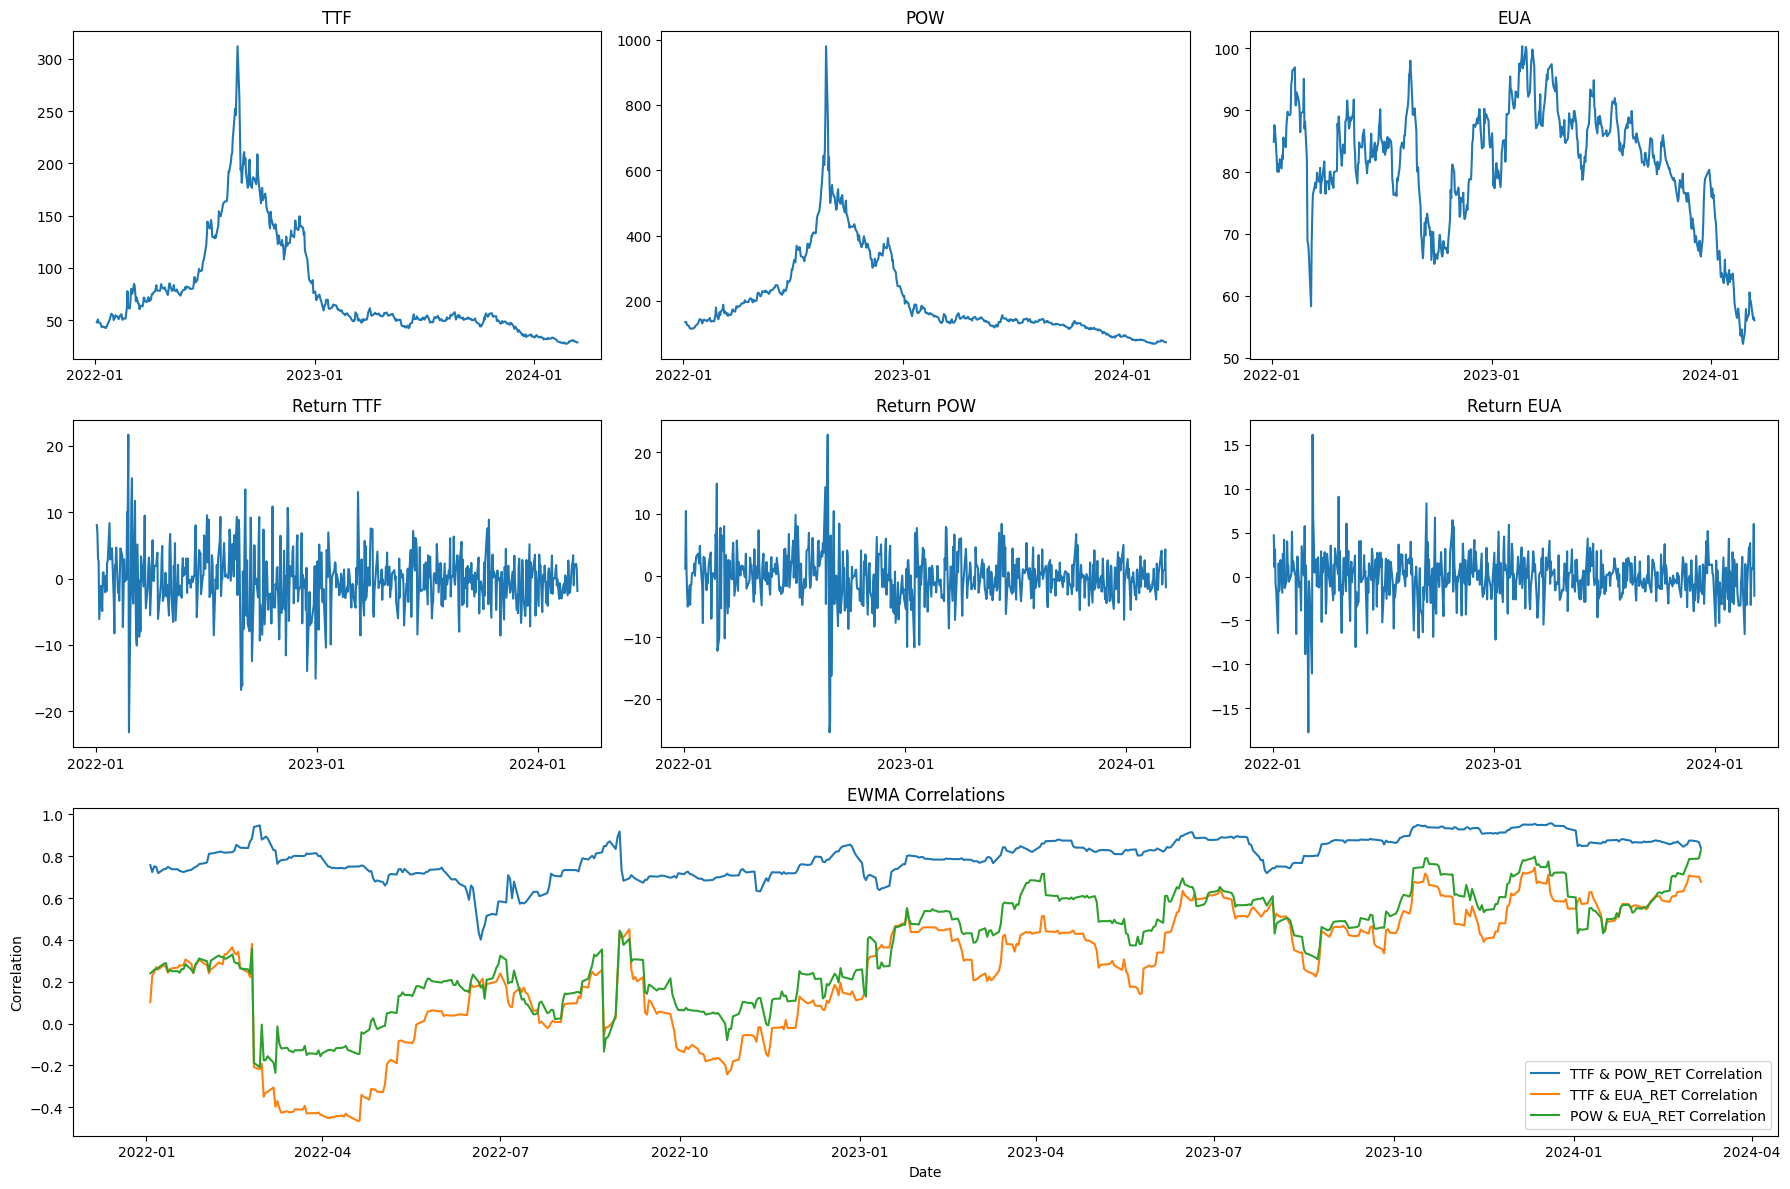

In [3]:
fig = pt.figure_1(df_all_close_fin_na[st_date:],df_comms_ret[st_date:])
plt.show(fig)

# Table 2 Summary statistics

In [4]:
import numpy as np
import pandas as pd
import scipy.stats as stats

df_stats = ut.calculate_statistics(ret_arr_gpe).round(2)
df_stats

,Max,Mean,Median,Min,Std,Skew,Kurtosis,Jarque-Bera,Jarque-Bera p-value
ttf,21.69,-0.05,0.07,-23.19,4.53,-0.17,2.81,186.51,0.0
pow,22.83,-0.08,-0.20,-25.42,4.12,-0.33,6.55,1009.85,0.0
eua,16.14,-0.07,0.06,-17.73,2.72,-0.33,5.58,737.66,0.0


# MLE estimation Table 3 and 6-8

This section runs estimation of all model described in paper. Log-likelihood AIC and BIC are printed out, Table 3 is then created manually

## SIngle regime

### Norm

In [5]:
# if fails needs to be restarted
mgarch_single_norm = mgarch_single(ret = ret_arr_gpe, dist='norm')
res_single_norm = mgarch_single_norm.fit()

In [6]:
params_single_norm = mgarch_single_norm.get_params(res_single_norm.x)

In [7]:
std_err_norm_single = ut.std_errors(mgarch_single_norm.norm_err, params_single_norm)

In [8]:
df_estimates = pd.DataFrame({'param':params_single_norm.round(3),'std_err':std_err_norm_single.round(2)})
df_estimates.T.round(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
param,-0.15,-0.20,-0.18,0.31,0.20,0.01,0.16,0.20,0.11,0.80,0.79,0.92,-0.19,-0.17,0.04,0.80,0.24,0.35
std_err,0.14,0.12,0.09,0.10,0.06,0.02,0.02,0.02,0.02,0.04,0.03,0.02,0.09,0.07,0.12,0.02,0.04,0.04


In [9]:
ut.return_lrt(mgarch_single_norm.loglik,res_single_norm.x,ret_arr_gpe)

Loglik: -4046.0
AIC: 8128.0
BIC: 8206.0


### Stu

In [10]:
mgarch_single_stu = mgarch_single(ret = ret_arr_gpe, dist='t')
res_single_stu= mgarch_single_stu.fit()

In [11]:
params_stu_single = mgarch_single_stu.get_params(res_single_stu.x)

In [12]:
std_err_stu_single = ut.std_errors(mgarch_single_norm.stu_err, params_stu_single)

In [13]:
df_estimates = pd.DataFrame({'param':params_stu_single.round(3),'std_err':std_err_stu_single.round(2)})
df_estimates.T.round(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
param,-0.11,-0.19,-0.10,0.23,0.16,0.02,0.13,0.16,0.06,0.85,0.84,0.95,-0.22,-0.19,0.28,0.83,0.30,0.44,5.58
std_err,0.14,0.11,0.09,0.11,0.07,0.02,0.03,0.03,0.02,0.04,0.03,0.02,0.12,0.09,0.29,0.02,0.04,0.04,0.74


In [14]:
ut.return_lrt(mgarch_single_stu.loglik,res_single_stu.x,ret_arr_gpe)

Loglik: -3983.0
AIC: 8004.0
BIC: 8086.0


## Two regimes

### Norm

In [15]:
# for two regime models estimated optimal initial parameters are used
res_no_mean_norm_init = pd.read_pickle('qmle_fit_res/res_no_mean_norm').x

In [16]:
# to start estimation from random state delete init_params argument
mgarch_no_mean_norm = mgarch(dist='norm',regime_mean=False,ar = False,regime_ar=False,ret = ret_arr_gpe,init_params=res_no_mean_norm_init)
res_no_mean_norm = mgarch_no_mean_norm.fit()

In [17]:
xsi_no_mean_norm,chi_no_mean_norm,condcorr,est_no_mean_norm,h1_no_mean_norm,h2_no_mean_norm,loglik_no_mean_norm = mgarch_no_mean_norm.get_smoothed_prob(res_no_mean_norm.x)

In [18]:
# estimatest displayed as array of arrays, no functionality to name params yet unfortunately
est_no_mean_norm

[array([-0.11755894, -0.12423289, -0.05926822]),
 array([0.16637029, 0.07102214, 0.0130508 ]),
 array([1.00493021, 0.71390217, 0.21345033]),
 array([0.06092473, 0.08699604, 0.03161328]),
 array([0.14759003, 0.22833957, 0.17693762]),
 array([0.89741951, 0.90042619, 0.96707969]),
 array([0.72846755, 0.69018059, 0.82118374]),
 array([-0.43241104, -0.14684034,  0.10823517]),
 array([[1.        , 0.89412433, 0.41037568],
        [0.89412433, 1.        , 0.55858573],
        [0.41037568, 0.55858573, 1.        ]]),
 array([[ 1.        ,  0.67939314, -0.00638342],
        [ 0.67939314,  1.        ,  0.03973308],
        [-0.00638342,  0.03973308,  1.        ]]),
 0.9568594455887605,
 0.889499460786987]

In [19]:
ut.return_lrt(loglik_no_mean_norm,res_no_mean_norm.x,ret_arr_gpe)

Loglik: -3930.0
AIC: 7925.0
BIC: 8063.0


### Norm regime switching mean

In [20]:
res_mean_norm_init = pd.read_pickle('qmle_fit_res/res_mean_norm').x

In [21]:
mgarch_mean_norm = mgarch(dist='norm',regime_mean=True,ar = False,regime_ar=False,ret = ret_arr_gpe,init_params=res_mean_norm_init)
res_mean_norm = mgarch_mean_norm.fit()

In [22]:
xsi_mean_norm,chi_mean_norm,condcorr,est_mean_norm,h1_mean_norm,h2_mean_norm,loglik_mean_norm = mgarch_mean_norm.get_smoothed_prob(res_mean_norm.x)

In [23]:
est_mean_norm

[array([ 0.07109686, -0.15211424, -0.41236462]),
 array([-0.10112907, -0.08853476,  0.01933731]),
 array([1.01751808, 0.77237391, 2.43752367]),
 array([0.18116637, 0.06986775, 0.00592014]),
 array([0.14688022, 0.22966564, 0.39453117]),
 array([0.05909112, 0.08630173, 0.02922904]),
 array([7.26691462e-01, 6.72365124e-01, 7.98268247e-07]),
 array([0.89458028, 0.90202686, 0.97193959]),
 array([-0.44521288, -0.14561864,  0.41479532]),
 array([[ 1.        ,  0.68324661, -0.01889054],
        [ 0.68324661,  1.        ,  0.02499091],
        [-0.01889054,  0.02499091,  1.        ]]),
 array([[1.        , 0.89554825, 0.41668319],
        [0.89554825, 1.        , 0.56755852],
        [0.41668319, 0.56755852, 1.        ]]),
 0.8927941307575021,
 0.9555133511792769]

In [24]:
ut.return_lrt(loglik_mean_norm,res_mean_norm.x,ret_arr_gpe)

Loglik: -3928.0
AIC: 7925.0
BIC: 8077.0


### Norm AR(1)

In [25]:
res_AR_norm_init = pd.read_pickle('qmle_fit_res/res_AR_norm').x

In [26]:
mgarch_AR_norm = mgarch(dist='norm',regime_mean=False,ar = True,regime_ar=False,ret = ret_arr_gpe,init_params=res_AR_norm_init)
res_AR_norm = mgarch_AR_norm.fit()

In [27]:
xsi_AR_norm,chi_AR_norm,condcorr,est_AR_norm,h1_AR_norm,h2_AR_norm,loglik_AR_norm = mgarch_AR_norm.get_smoothed_prob(res_AR_norm.x)

In [28]:
est_AR_norm

[array([-0.13964049, -0.13846377, -0.05597623]),
 array([-0.06000483, -0.02878804, -0.03589173]),
 array([0.16483965, 0.07723262, 0.01306549]),
 array([1.17883732, 0.72577015, 0.21501827]),
 array([0.06104802, 0.08832128, 0.03086657]),
 array([0.16688853, 0.24067635, 0.18323161]),
 array([0.89813808, 0.89707099, 0.96770516]),
 array([0.68853256, 0.68036149, 0.81646233]),
 array([-0.41794684, -0.13570814,  0.100366  ]),
 array([[1.        , 0.89452131, 0.41621485],
        [0.89452131, 1.        , 0.56163825],
        [0.41621485, 0.56163825, 1.        ]]),
 array([[ 1.        ,  0.69419278, -0.00765735],
        [ 0.69419278,  1.        ,  0.03789791],
        [-0.00765735,  0.03789791,  1.        ]]),
 0.9609751970129774,
 0.8939089976712892]

In [29]:
std_err_norm_AR= ut.std_errors(mgarch_AR_norm.norm_err, mgarch_AR_norm.get_params(res_AR_norm.x))

In [30]:
df_estimates = pd.DataFrame({'param':mgarch_AR_norm.get_params(res_AR_norm.x),'std_err':std_err_norm_AR.round(2)})
df_estimates.T.round(2)

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
param,-0.14,-0.14,-0.06,-0.06,-0.03,-0.04,0.16,0.08,0.01,1.18,...,-0.14,0.10,0.89,0.42,0.56,0.69,-0.01,0.04,0.96,0.89
std_err,0.09,0.09,0.09,0.03,0.03,0.04,0.08,0.04,0.01,0.65,...,0.09,0.21,0.01,0.04,0.04,0.04,0.09,0.09,0.01,0.05


### Stu t

In [31]:
res_no_mean_stu_init = pd.read_pickle('qmle_fit_res/res_no_mean_stu').x

In [32]:
mgarch_no_mean_stu = mgarch(dist='t',regime_mean=False,ar = False,regime_ar=False,ret = ret_arr_gpe,init_params=res_no_mean_stu_init)
res_no_mean_stu = mgarch_no_mean_stu.fit()

In [33]:
xsi_no_mean_stu,chi_no_mean_stu,condcorr,est_no_mean_stu,h1_no_mean_stu,h2_no_mean_stu,loglik_no_mean_stu = mgarch_no_mean_stu.get_smoothed_prob(res_no_mean_stu.x)

In [34]:
est_no_mean_stu

[array([-0.06100325, -0.11490779, -0.05212552]),
 array([0.28152905, 0.06106955, 0.01352459]),
 array([0.9635849 , 0.73884917, 0.43711612]),
 array([0.06943344, 0.08849248, 0.03590076]),
 array([0.14109696, 0.21461112, 0.1080433 ]),
 array([0.85830008, 0.90660091, 0.9644853 ]),
 array([0.72419642, 0.67199915, 0.78208224]),
 array([-0.39451409, -0.12779795,  0.27385539]),
 array([[1.        , 0.89994035, 0.45988488],
        [0.89994035, 1.        , 0.59931373],
        [0.45988488, 0.59931373, 1.        ]]),
 array([[ 1.        ,  0.70179571, -0.00224123],
        [ 0.70179571,  1.        ,  0.0842102 ],
        [-0.00224123,  0.0842102 ,  1.        ]]),
 0.9699328628918195,
 0.947799275122013,
 12.380355863472454]

In [35]:
ut.return_lrt(loglik_no_mean_stu,res_no_mean_stu.x,ret_arr_gpe)

Loglik: -3924.0
AIC: 7914.0
BIC: 8057.0


### Stu t regime switching mean

In [36]:
res_mean_stu_init = pd.read_pickle('qmle_fit_res/res_mean_stu').x

In [37]:
mgarch_mean_stu = mgarch(dist='t',regime_mean=True,ar = False,regime_ar=False,ret = ret_arr_gpe,init_params=res_mean_stu_init)
res_mean_stu = mgarch_mean_stu.fit()

In [38]:
xsi_mean_stu,chi_mean_stu,condcorr,est_mean_stu,h1_mean_stu,h2_mean_stu,loglik_mean_stu = mgarch_mean_stu.get_smoothed_prob(res_mean_stu.x)

In [39]:
est_mean_stu

[array([ 0.01824486, -0.11450744, -0.25074861]),
 array([-0.059529  , -0.09517128, -0.00666556]),
 array([1.03405743, 0.79853   , 2.4727712 ]),
 array([0.26232437, 0.06531545, 0.00932417]),
 array([0.14328753, 0.21972246, 0.30725661]),
 array([0.06750001, 0.08975017, 0.03350157]),
 array([7.14840151e-01, 6.59386093e-01, 2.78020693e-04]),
 array([0.86478475, 0.9031805 , 0.96782074]),
 array([-0.42850844, -0.13919807,  0.36296652]),
 array([[ 1.        ,  0.69749554, -0.01308442],
        [ 0.69749554,  1.        ,  0.06370492],
        [-0.01308442,  0.06370492,  1.        ]]),
 array([[1.        , 0.89800858, 0.4478624 ],
        [0.89800858, 1.        , 0.59012923],
        [0.4478624 , 0.59012923, 1.        ]]),
 0.9377866796473487,
 0.9673130034624157,
 14.596330496421846]

In [40]:
ut.return_lrt(loglik_mean_stu,res_mean_stu.x,ret_arr_gpe)

Loglik: -3923.0
AIC: 7918.0
BIC: 8073.0


### Stu t AR(1)

In [41]:
res_AR_stu_init = pd.read_pickle('qmle_fit_res/res_AR_stu').x

In [42]:
mgarch_AR_stu = mgarch(dist='t',regime_mean=False,ar = True,regime_ar=False,ret = ret_arr_gpe,init_params=res_AR_stu_init)
res_AR_stu = mgarch_AR_stu.fit()

In [43]:
xsi_AR_stu,chi_AR_stu,condcorr_stu_ar,est_AR_stu,h1_AR_stu,h2_AR_stu,loglik_AR_stu = mgarch_AR_stu.get_smoothed_prob(res_AR_stu.x)

loglik_AR_stu

array([[-3910.34915161]])

In [44]:
est_AR_stu

[array([-0.09734955, -0.13546353, -0.05217047]),
 array([-0.06588636, -0.03101346, -0.02351228]),
 array([0.30039082, 0.07022342, 0.01347893]),
 array([1.11798259, 0.76957164, 0.48202637]),
 array([0.07121907, 0.0910261 , 0.03515857]),
 array([0.1580115 , 0.22552394, 0.11105729]),
 array([0.85138478, 0.90127439, 0.96507094]),
 array([0.6872164 , 0.65829171, 0.76534463]),
 array([-0.37398571, -0.11458367,  0.28307941]),
 array([[1.        , 0.90073305, 0.46306905],
        [0.90073305, 1.        , 0.60040407],
        [0.46306905, 0.60040407, 1.        ]]),
 array([[ 1.        ,  0.71661938, -0.00379689],
        [ 0.71661938,  1.        ,  0.0829792 ],
        [-0.00379689,  0.0829792 ,  1.        ]]),
 0.9713706300276633,
 0.9484778013236438,
 12.465302109539463]

In [45]:
std_err_stu_AR= ut.std_errors(mgarch_AR_stu.stu_err, mgarch_AR_stu.get_params(res_AR_stu.x))

In [46]:
df_estimates = pd.DataFrame({'param':mgarch_AR_stu.get_params(res_AR_stu.x).round(2),'std_err':std_err_stu_AR.round(2)})
df_estimates.T.round(2)

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
param,-0.10,-0.14,-0.05,-0.07,-0.03,-0.02,0.30,0.07,0.01,1.12,...,0.28,0.90,0.46,0.60,0.72,-0.00,0.08,0.97,0.95,12.47
std_err,0.08,0.09,0.09,0.04,0.04,0.04,0.18,0.04,0.02,0.61,...,0.29,0.01,0.05,0.04,0.04,0.08,0.08,0.01,0.02,3.90


### Skewed t 

In [47]:
res_no_mean_skewed_t_init = pd.read_pickle('qmle_fit_res/res_no_mean_skewed_t').x

In [48]:
mgarch_skewed_t = mgarch(dist='skewed_t',regime_mean=False,ar = False,regime_ar=False,ret = ret_arr_gpe,init_params=res_no_mean_skewed_t_init)
res_no_mean_skewed_t = mgarch_skewed_t.fit()

In [49]:
xsi_skewed_t,chi_skewed_t,condcorr,est_skewed_t,h1_skewed_t,h2_skewed_t,loglik_skewed_t = mgarch_skewed_t.get_smoothed_prob(res_no_mean_skewed_t.x)

In [50]:
est_skewed_t

[array([1.05097043, 0.37523496, 0.16235652]),
 array([0.80933983, 0.76186154, 0.35661268]),
 array([0.27342353, 0.0608517 , 0.00687589]),
 array([0.10269276, 0.19940498, 0.09812829]),
 array([0.0707539 , 0.08705797, 0.03396221]),
 array([0.792821  , 0.68418211, 0.81314748]),
 array([0.86974814, 0.90895698, 0.96791333]),
 array([-0.63773197, -0.24667902,  0.29012661]),
 array([-1.17087101, -0.5121931 , -0.22074955]),
 array([[ 1.        ,  0.7023756 , -0.0024798 ],
        [ 0.7023756 ,  1.        ,  0.08489364],
        [-0.0024798 ,  0.08489364,  1.        ]]),
 array([[1.        , 0.90148255, 0.45476165],
        [0.90148255, 1.        , 0.5928873 ],
        [0.45476165, 0.5928873 , 1.        ]]),
 0.9464645212738748,
 0.9695271643466422,
 12.434615641137576]

In [51]:
ut.return_lrt(loglik_skewed_t,res_no_mean_skewed_t.x,ret_arr_gpe)

Loglik: -3924.0
AIC: 7919.0
BIC: 8075.0


### Skewed t regime switching mean

In [52]:
res_mean_skewed_t = pd.read_pickle('qmle_fit_res/res_mean_skewed_t').x

In [53]:
mgarch_mean_skewed_t = mgarch(dist='skewed_t',regime_mean=True,ar = False,regime_ar=False,ret = ret_arr_gpe,init_params=res_mean_skewed_t)
res_mean_skewed_t = mgarch_mean_skewed_t.fit()

In [54]:
xsi_mean_skewed_t,chi_mean_skewed_t,condcorr,est_mean_skewed_t,h1_mean_skewed_t,h2_mean_skewed_t,loglik_mean_skewed_t = mgarch_mean_skewed_t.get_smoothed_prob(res_mean_skewed_t.x)

In [55]:
est_mean_skewed_t

[array([ 0.7869582 ,  0.14673517, -0.06093603]),
 array([ 0.93303913,  0.04984122, -0.35060846]),
 array([0.18984498, 0.05704905, 0.01439984]),
 array([0.64194781, 0.68839684, 0.20351122]),
 array([0.06023574, 0.08120131, 0.031311  ]),
 array([0.10785542, 0.20689423, 0.11691966]),
 array([0.89942795, 0.91241417, 0.96712619]),
 array([0.82342611, 0.70285935, 0.85861404]),
 array([-0.59398326, -0.19745133,  0.29812365]),
 array([-0.90444949, -0.24907339,  0.06176218]),
 array([[1.        , 0.89863455, 0.42675044],
        [0.89863455, 1.        , 0.57292245],
        [0.42675044, 0.57292245, 1.        ]]),
 array([[1.        , 0.68477285, 0.02154947],
        [0.68477285, 1.        , 0.07648862],
        [0.02154947, 0.07648862, 1.        ]]),
 0.9622538418681655,
 0.9162926205068003,
 14.647277723163944]

### Skewed t AR

In [56]:
res_AR_skewed_t = pd.read_pickle('qmle_fit_res/res_AR_skewed_t').x

In [57]:
mgarch_AR_skewed_t = mgarch(dist='skewed_t',regime_mean=False,ar = True,regime_ar=False,ret = ret_arr_gpe,init_params=res_AR_skewed_t)
res_AR_skewed_t = mgarch_AR_skewed_t.fit()

In [58]:
xsi_AR_skewed_t,chi_AR_skewed_t,condcorr,est_AR_skewed_t,h1_AR_skewed_t,h2_AR_skewed_t,loglik_AR_skewed_t = mgarch_AR_skewed_t.get_smoothed_prob(res_AR_skewed_t.x)

loglik_AR_skewed_t

array([[-3909.94856219]])

In [59]:
est_AR_skewed_t

[array([ 0.49631846,  0.07169576, -0.09490498]),
 array([-0.06507315, -0.03352872, -0.02454447]),
 array([0.30217337, 0.06905824, 0.01471782]),
 array([1.00041808, 0.77806276, 0.4681402 ]),
 array([0.06926082, 0.08957427, 0.03605526]),
 array([0.12841507, 0.21645147, 0.11078977]),
 array([0.85786672, 0.90337528, 0.96403262]),
 array([0.73727679, 0.66488394, 0.77041559]),
 array([-0.53143451, -0.17178383,  0.2905146 ]),
 array([-0.65022753, -0.21774145,  0.04856096]),
 array([[1.        , 0.90212472, 0.46628965],
        [0.90212472, 1.        , 0.60147273],
        [0.46628965, 0.60147273, 1.        ]]),
 array([[ 1.        ,  0.71805129, -0.00396661],
        [ 0.71805129,  1.        ,  0.08355473],
        [-0.00396661,  0.08355473,  1.        ]]),
 0.9717165669619321,
 0.949883783780924,
 11.973970251511975]

In [60]:
std_err_skewed_t_AR= ut.std_errors(mgarch_AR_skewed_t.skewed_t_err, mgarch_AR_skewed_t.get_params(res_AR_skewed_t.x))

In [61]:
df_estimates = pd.DataFrame({'param':mgarch_AR_skewed_t.get_params(res_AR_skewed_t.x).round(2),'std_err':std_err_skewed_t_AR.round(2)})
df_estimates.T.round(2)

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
param,0.50,0.07,-0.09,-0.07,-0.03,-0.02,0.3,0.07,0.01,1.00,...,0.60,0.72,-0.00,0.08,-0.65,-0.22,0.05,0.97,0.95,11.97
std_err,0.19,0.07,0.10,0.03,0.03,0.04,0.2,0.04,0.02,0.54,...,0.05,0.04,0.08,0.08,0.27,0.15,0.15,0.01,0.02,3.62


## Three regimes

### Norm

In [62]:
res_no_mean_norm_3_init = pd.read_pickle('qmle_fit_res/res_no_mean_norm_3').x

In [63]:
mgarch_norm_3_regimes = mgarch_3_regimes(dist='norm',regime_mean=False,ret = ret_arr_gpe,init_params=res_no_mean_norm_3_init)
res_no_mean_norm_3 = mgarch_norm_3_regimes.fit()

In [64]:
xsi_3_norm,chi_3_norm,condcorr_3_norm,est_3_norm,h1_3_norm,h2_3_norm,h3_3_norm,loglik_3_norm = mgarch_norm_3_regimes.get_smoothed_prob(res_no_mean_norm_3.x)

In [65]:
est_3_norm

[array([-0.10313251, -0.12390481, -0.08996603]),
 array([1.04560891, 0.70003294, 0.12969248]),
 array([0.16307288, 0.07180278, 0.0160538 ]),
 array([0.08025784, 1.16364976, 0.57452854]),
 array([0.15839298, 0.2380621 , 0.21025593]),
 array([0.06817527, 0.08940312, 0.03590236]),
 array([0.37139156, 0.05548583, 0.47364882]),
 array([0.72310026, 0.69561232, 0.82716488]),
 array([0.8928806 , 0.89884842, 0.96267094]),
 array([0.0644684 , 0.17901615, 0.18398283]),
 array([-0.3537292 , -0.12905286, -0.08192296]),
 [array([[1.        , 0.70166528, 0.01834057],
         [0.70166528, 1.        , 0.03847026],
         [0.01834057, 0.03847026, 1.        ]]),
  array([[1.        , 0.89564571, 0.41799521],
         [0.89564571, 1.        , 0.56202769],
         [0.41799521, 0.56202769, 1.        ]]),
  array([[ 1.        , -0.06353954, -0.26851783],
         [-0.06353954,  1.        ,  0.92609672],
         [-0.26851783,  0.92609672,  1.        ]])],
 array([[8.34980232e-01, 8.94366123e-09, 9.999391

In [66]:
ut.return_lrt(loglik_3_norm,res_no_mean_norm_3.x,ret_arr_gpe)

Loglik: -3915.0
AIC: 7927.0
BIC: 8134.0


### Stu

In [67]:
res_no_mean_stu_3_init = pd.read_pickle('qmle_fit_res/res_no_mean_stu_3').x

In [68]:
mgarch_stu_3_regimes = mgarch_3_regimes(dist='t',regime_mean=False,ret = ret_arr_gpe,init_params=res_no_mean_stu_3_init)
res_no_mean_stu_3 = mgarch_stu_3_regimes.fit()

In [69]:
xsi_3_stu,chi_3_stu,condcorr_3_stu,est_3_stu,h1_3_stu,h2_3_stu,h3_3_stu,loglik_3_stu = mgarch_stu_3_regimes.get_smoothed_prob(res_no_mean_stu_3.x)

In [70]:
est_3_stu

[array([-0.1591829 , -0.15953011,  0.09063194]),
 array([0.77570276, 0.6499319 , 0.49134504]),
 array([0.33925889, 0.0655927 , 0.01231491]),
 array([8.32891491e-07, 1.39992577e-05, 1.03894966e-25]),
 array([0.12904079, 0.21499626, 0.05388846]),
 array([6.80771937e-02, 8.14593206e-02, 1.10440040e-23]),
 array([2.28847637, 0.69763122, 0.14221661]),
 array([0.75700585, 0.68107466, 0.80373175]),
 array([0.84203717, 0.91174835, 0.99404397]),
 array([0.08984441, 0.52835982, 0.78170557]),
 array([-0.46813585, -0.15747115,  1.        ]),
 [array([[ 1.        ,  0.69585312, -0.02614837],
         [ 0.69585312,  1.        ,  0.07337495],
         [-0.02614837,  0.07337495,  1.        ]]),
  array([[1.        , 0.90332165, 0.45244816],
         [0.90332165, 1.        , 0.59978482],
         [0.45244816, 0.59978482, 1.        ]]),
  array([[1.        , 0.84514862, 0.84514862],
         [0.84514862, 1.        , 0.44740033],
         [0.84514862, 0.44740033, 1.        ]])],
 array([[0.96328135, 0.00

In [71]:
ut.return_lrt(loglik_3_stu,res_no_mean_stu_3.x,ret_arr_gpe)

Loglik: -3918.0
AIC: 7933.0
BIC: 8145.0


## DCC

### Norm

In [72]:
norm_dcc = dcc(ret = ret_arr_gpe,dist = 'norm')
estdccn = norm_dcc.fit()

In [73]:
ut.return_lrt(norm_dcc.loglik,estdccn.x,ret_arr_gpe)

Loglik: -4015.0
AIC: 8064.0
BIC: 8138.0


### Stu t

In [74]:
stu_dcc = dcc(ret = ret_arr_gpe,dist = 't')
estdcct = stu_dcc.fit()

In [75]:
ut.return_lrt(stu_dcc.loglik,estdcct.x,ret_arr_gpe)

Loglik: -3960.0
AIC: 7956.0
BIC: 8034.0


In [76]:
corrstudcc = stu_dcc.stu_dcc_corr_mult(estdcct.x)

# Figure 2 Smoothed probabilities

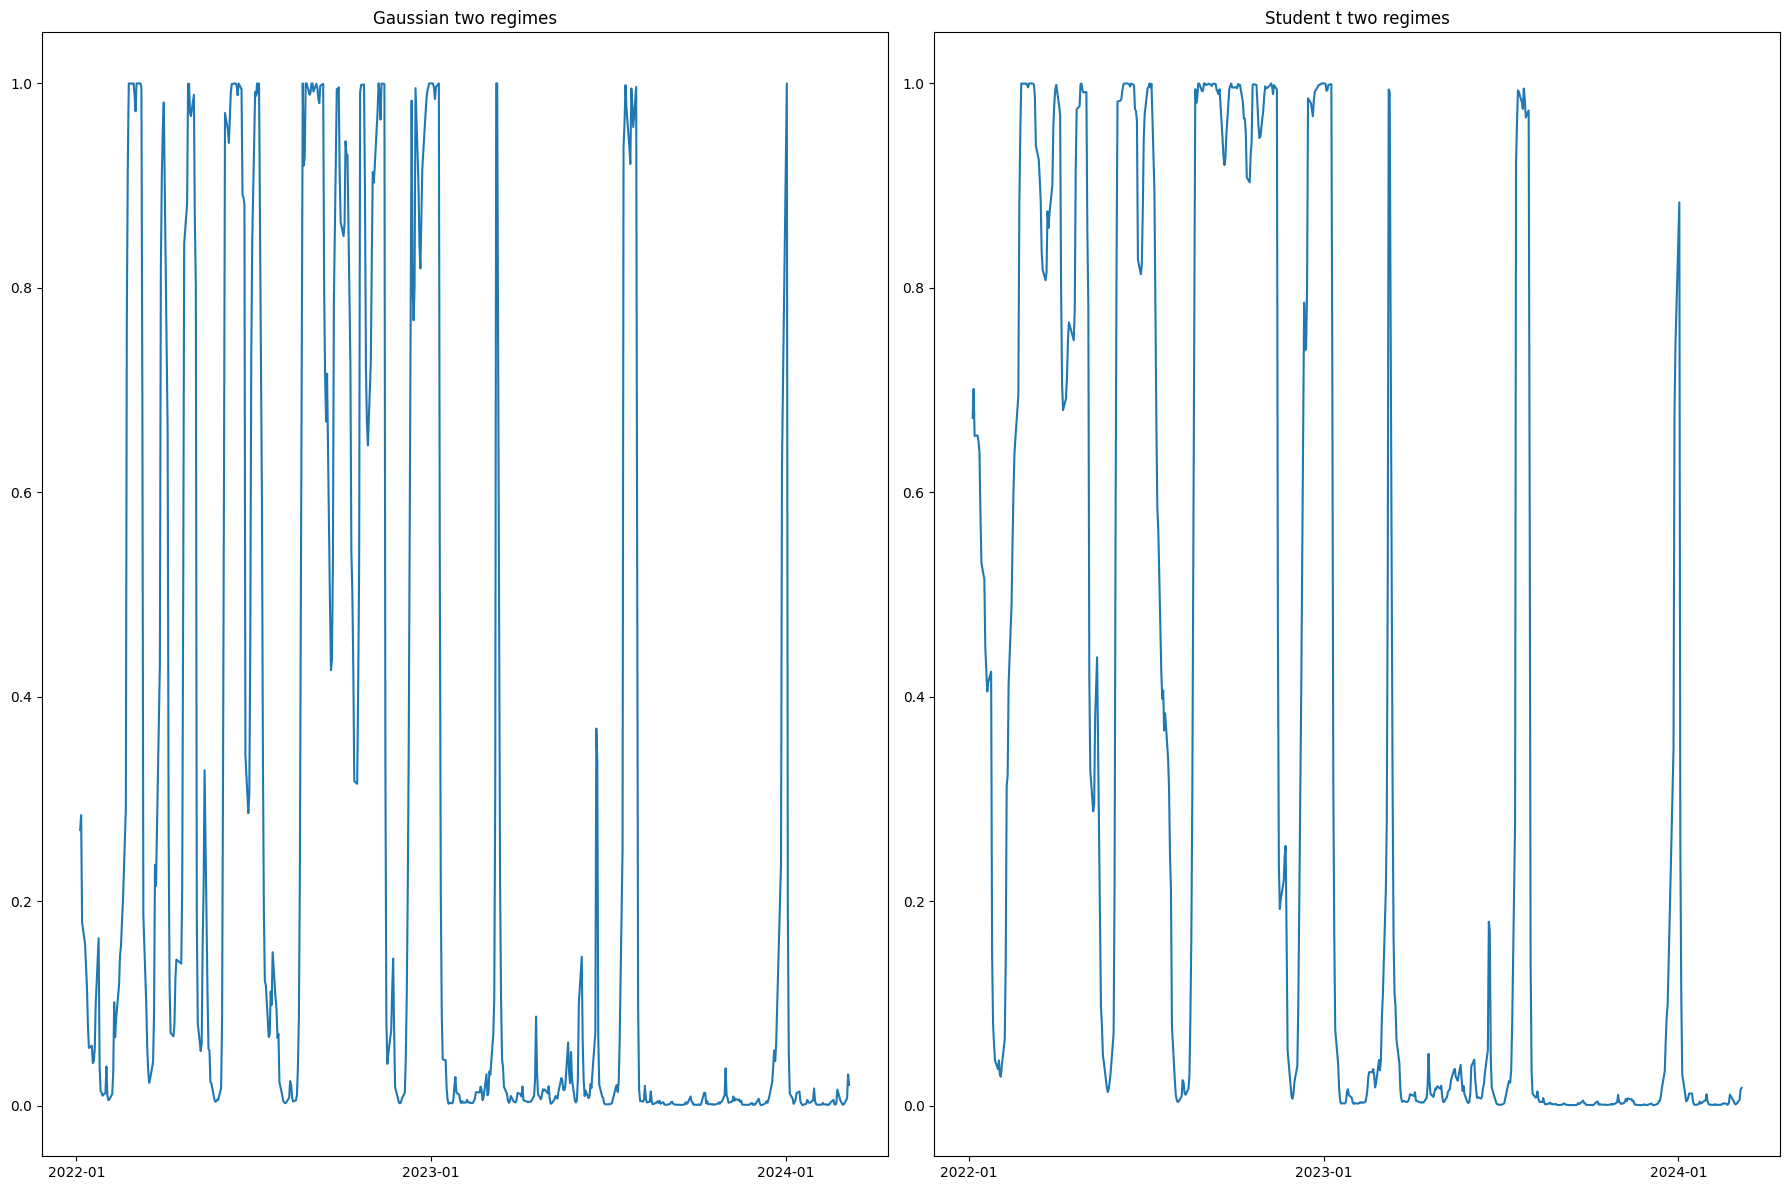

In [77]:
fig_2 = pt.figure_2(df_comms_ret[st_date:],chi_AR_norm,chi_AR_stu)
plt.show(fig_2)

# Figure 3 Correlations

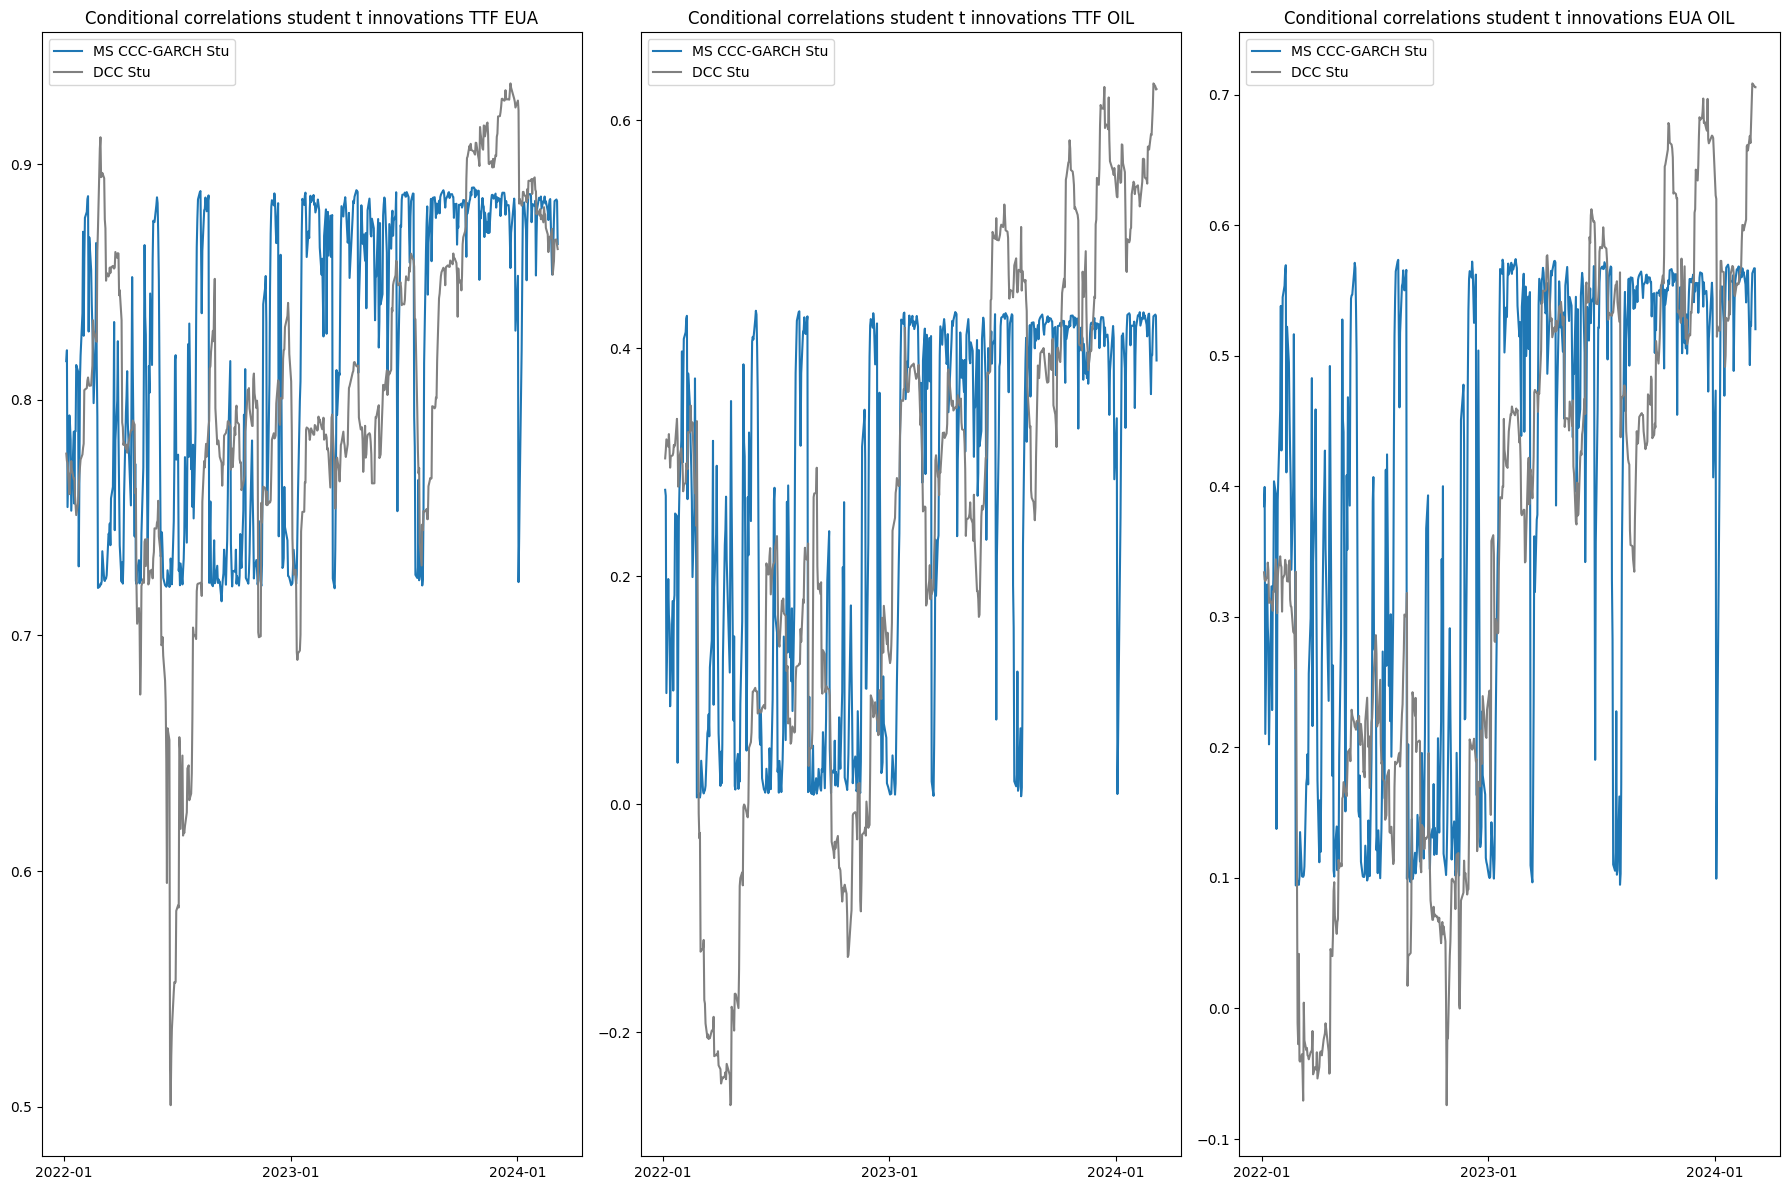

In [78]:
fig_3 = pt.figure_3(df_comms_ret[st_date:],condcorr_stu_ar,corrstudcc)
plt.show(fig_3)

# LR Test Tables 4 and 5 

LR tests conducted individually, tables shown in paper constructed manually 


## LRT regimes

Norm 2 vs Norm 1

In [79]:
ut.LRT_test(loglik_no_mean_norm, mgarch_single_norm.loglik,res_no_mean_norm.x,res_single_norm.x)

{'LRT': array([[230.88585562]]), 'p_value': array([[0.]])}

Note: when tested it appears that norm single model can get -inf solution without code failing. in such case estimation of single model must be re run.

Stu 2 vs Stu 1 

In [80]:
ut.LRT_test( loglik_no_mean_stu, mgarch_single_stu.loglik,res_no_mean_stu.x,res_single_stu.x)

{'LRT': array([[117.48868133]]), 'p_value': array([[0.]])}

Norm 3 vs Norm 2

In [81]:
ut.LRT_test( loglik_3_norm, loglik_no_mean_norm,res_no_mean_norm_3.x,res_no_mean_norm.x)

{'LRT': array([[30.15636055]]), 'p_value': array([[0.01720814]])}

Stu 3 vs Stu 2

In [82]:
ut.LRT_test( loglik_3_stu, loglik_no_mean_stu,res_no_mean_stu_3.x,res_no_mean_stu.x)

{'LRT': array([[13.09227383]]), 'p_value': array([[0.6659994]])}

## LRT mean spec

### no mean norm vs mean norm

In [83]:
ut.LRT_test( -(res_mean_norm.fun * ret_arr_gpe.shape[0]), loglik_no_mean_norm,res_mean_norm.x,res_no_mean_norm.x)

{'LRT': array([[5.40274747]]), 'p_value': array([[0.1445725]])}

### no mean norm vs AR norm

In [84]:
ut.LRT_test( -(res_AR_norm.fun * ret_arr_gpe.shape[0]), loglik_no_mean_norm,res_AR_norm.x,res_no_mean_norm.x)

{'LRT': array([[14.20287114]]), 'p_value': array([[0.00264162]])}

### no mean stu vs mean stu

In [85]:
ut.LRT_test( -(res_mean_stu.fun * ret_arr_gpe.shape[0]), loglik_no_mean_stu,res_mean_stu.x,res_no_mean_stu.x)

{'LRT': array([[2.7420151]]), 'p_value': array([[0.43313442]])}

### no mean stu vs AR stu

In [86]:
ut.LRT_test( -(res_AR_stu.fun * ret_arr_gpe.shape[0]), loglik_no_mean_stu,res_AR_stu.x,res_no_mean_stu.x)

{'LRT': array([[13.64257367]]), 'p_value': array([[0.00343434]])}

### no mean skewed t vs mean skewed t 

In [87]:
ut.LRT_test( -(res_mean_skewed_t.fun * ret_arr_gpe.shape[0]), loglik_skewed_t,res_mean_skewed_t.x,res_no_mean_skewed_t.x)

{'LRT': array([[1.43076423]]), 'p_value': array([[0.69833953]])}

### no mean skewed t vs AR skewed t 

In [88]:
ut.LRT_test( -(res_AR_skewed_t.fun * ret_arr_gpe.shape[0]), loglik_skewed_t,res_AR_skewed_t.x,res_no_mean_skewed_t.x)

{'LRT': array([[13.19785044]]), 'p_value': array([[0.0042277]])}

# VaR test

In [89]:
df_backtest = df_comms_ret['2020-10-01':]

next cells include backtest of 1 period ahead var estimation. resuts of models rolling window fit re estimation stored in folders fcst_***

In [90]:
import os
from tqdm import tqdm 

window_size = 550
n = 3
h = 1

f_end = 250
mu_list = []

w_list = []

date = []
var_list_stu_dcc =  []

ones = np.ones(n)
for i in tqdm(range(0,f_end,h)):

    ret_temp = df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].values
    tstamp = str(df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].iloc[-1].name.date()).replace('-','_')

    filename = f'fcst_dcc_stu/res_{tstamp}.pkl'
    if os.path.exists(filename):
        res_temp = pd.read_pickle(filename)
        stu_dcc = dcc(ret = ret_temp,dist = 't')
    else:
        stu_dcc = dcc(ret = ret_temp,dist = 't')


    Q, R, h_dcc, S, w, A, B, G, alpha, beta, nu =  stu_dcc.tdccfore(res_temp)
    dcc_fore  =  stu_dcc.dccsim(Q, R, h_dcc, S, w, A, B, G, alpha, beta, nu, 1)
    cov_m = np.reshape(dcc_fore[:,0], (3, 3))
    
    d = i + h

    for d_ar in range(0,h):
        if f_end -i - 1 == 0:
            mu = res_temp[:n]
            alpha = 0.95
            weights= np.array([-0.33,-0.33,-0.33])
            portfolio_var = np.dot(mu, weights) + np.sqrt(np.dot(weights.T, np.dot(cov_m, weights))) * scipy.stats.t.ppf(alpha, df=nu)
            ret_pnl = df_backtest.iloc[:-f_end].iloc[-h:]

            pnl_d = ret_pnl.values @ weights.T
            var_list_stu_dcc.append(portfolio_var)
            
        else:
            mu = res_temp[:n]
            alpha = 0.95
            weights= np.array([-0.33,-0.33,-0.33])
            portfolio_var = np.dot(mu, weights) + np.sqrt(np.dot(weights.T, np.dot(cov_m, weights))) * scipy.stats.t.ppf(alpha, df=nu)
            ret_pnl = df_backtest.iloc[:-f_end+d].iloc[-h:].iloc[d_ar]
            pnl_d = ret_pnl.values @ weights.T
            var_list_stu_dcc.append(portfolio_var)


 16%|█▋        | 41/250 [00:00<00:04, 44.92it/s]

100%|██████████| 250/250 [00:06<00:00, 38.26it/s]


In [91]:
window_size = 550
n = 3
h = 1

f_end = 250
xsi_list = []
mu_list = []

w_list = []

date = []
var_list_stu =  []
rret_short = []
rret_long = []

for i in tqdm(range(0,f_end,h)):

    ret_temp = df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].values
    tstamp = str(df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].iloc[-1].name.date()).replace('-','_')

    filename = f'fcst_ar_stu/res_{tstamp}.pkl'
    if os.path.exists(filename):
        res_temp = pd.read_pickle(filename)
        mgarch_gpe_ar = mgarch(dist='t',regime_mean=False,ar = True,regime_ar=False,ret = ret_temp, init_params=res_temp)
    else:
        mgarch_gpe_ar = mgarch(dist='t',regime_mean=False,ar = True,regime_ar=False,ret = ret_temp,init_params=res_temp)

    xsi,chi,condcorr,est,h1,h2,loglik = mgarch_gpe_ar.get_smoothed_prob(res_temp)
    w1,w2,phi1,phi2,A1,A2,B1,B2,G,p,q,nu,P,R1,R2,sigma1init,sigma2init,pinit  = mgarch_gpe_ar.params_for_fcst_ar(res_temp)
    sigmafore, condcov, condcorr  = mgarch_gpe_ar.forecastst(w1, w2, A1, A2, B1, B2, P, R1, R2, G, G, sigma1init, sigma2init, pinit,nu, h)   
    cov_m = condcov[-1]
    
    d = i + h
    weights_long = np.array([0.33,0.33,0.33])
    weights_short = np.array([-0.33,-0.33,-0.33])
    
    for d_ar in range(0,h):
        if f_end -i - 1 == 0:
            mu = (res_temp[:n]+ (df_backtest.iloc[-(f_end -i):].iloc[d_ar].values-res_temp[:n]) * phi1)
            alpha = 0.95
            weights= np.array([-0.33,-0.33,-0.33])
            portfolio_var = np.dot(mu, weights) + np.sqrt(np.dot(weights.T, np.dot(cov_m, weights))) * scipy.stats.t.ppf(alpha, df=nu)
            ret_pnl = df_backtest.iloc[:-f_end].iloc[-h:].iloc[0]

            rret_short.append(ret_pnl.values @ weights_short.T)
            rret_long.append(ret_pnl.values @ weights_long.T)
            
            var_list_stu.append(portfolio_var)
            
        else:
            mu = (res_temp[:n] + (df_backtest.iloc[:-f_end+d].iloc[-h-1:].iloc[d_ar].values - res_temp[:n] ) * phi1)

            alpha = 0.95

            portfolio_var = np.dot(mu, weights) + np.sqrt(np.dot(weights.T, np.dot(cov_m, weights))) * scipy.stats.t.ppf(alpha, df=nu)
            ret_pnl = df_backtest.iloc[:-f_end+d].iloc[-h:].iloc[d_ar]

            

            rret_short.append(ret_pnl.values @ weights_short.T)
            rret_long.append(ret_pnl.values @ weights_long.T)
            var_list_stu.append(portfolio_var)

100%|██████████| 250/250 [00:27<00:00,  8.96it/s]


In [92]:
# VaR MS CCC-GARCH Norm

window_size = 550
n = 3
h = 1

f_end = 250

var_list_norm =  []
rret = []


for i in tqdm(range(0,f_end,h)):

    ret_temp = df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].values
    tstamp = str(df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].iloc[-1].name.date()).replace('-','_')

    filename = f'fcst_ar_norm/res_{tstamp}.pkl'
    if os.path.exists(filename):
        res_temp = pd.read_pickle(filename)
        mgarch_norm_ar = mgarch(dist='norm',regime_mean=False,ar = True,regime_ar=False,ret = ret_temp, init_params=res_temp)
    else:
        mgarch_norm_ar = mgarch(dist='norm',regime_mean=False,ar = True,regime_ar=False,ret = ret_temp,init_params=res_temp)


    xsi,chi,condcorr,est,h1,h2,loglik = mgarch_norm_ar.get_smoothed_prob(res_temp)
    w1,w2,phi1,phi2,A1,A2,B1,B2,G,p,q,P,R1,R2,sigma1init,sigma2init,pinit  = mgarch_norm_ar.params_for_fcst_ar(res_temp)
    sigmafore, condcov, condcorr  = mgarch_norm_ar.forecasts_norm(w1, w2, A1, A2, B1, B2, P, R1, R2, G, G, sigma1init, sigma2init, pinit, h)   
    cov_m = condcov[-1]
    
    d = i + h

    for d_ar in range(0,h):
        if f_end -i - 1 == 0:
            mu = (res_temp[:n]+ (df_backtest.iloc[-(f_end -i):].iloc[d_ar].values-res_temp[:n]) * phi1)
            alpha = 0.95
            weights= np.array([-0.33,-0.33,-0.33])
            portfolio_var = np.dot(mu, weights) + np.sqrt(np.dot(weights.T, np.dot(cov_m, weights))) * scipy.stats.norm.ppf(alpha)
            ret_pnl = df_backtest.iloc[:-f_end].iloc[-h:].iloc[0]
            

            pnl_d = ret_pnl.values @ weights.T
            rret.append(pnl_d)
            var_list_norm.append(portfolio_var)
            
        else:
            mu = (res_temp[:n] + (df_backtest.iloc[:-f_end+d].iloc[-h-1:].iloc[d_ar].values - res_temp[:n] ) * phi1)

            alpha = 0.95
            weights= np.array([-0.33,-0.33,-0.33])
            portfolio_var = np.dot(mu, weights) + np.sqrt(np.dot(weights.T, np.dot(cov_m, weights)))* scipy.stats.norm.ppf(alpha)
            ret_pnl = df_backtest.iloc[:-f_end+d].iloc[-h:].iloc[d_ar]

            
            pnl_d = ret_pnl.values @ weights.T
            rret.append(pnl_d)
            var_list_norm.append(portfolio_var)

  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 250/250 [00:27<00:00,  8.95it/s]


In [93]:
# VaR MS CCC-GARCH Skewed t

condcov_l, condcorr_l  = [],[]
window_size = 550
n = 3
h = 1

f_end = 250

var_list_stu_skewed_t_5 =  []
var_list_stu_skewed_t_95 =  []

np.random.seed(777)

ones = np.ones(n)
for i in tqdm(range(0,f_end,h)):

    ret_temp = df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].values
    tstamp = str(df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].iloc[-1].name.date()).replace('-','_')

    filename = f'fcst_ar_skew/res_{tstamp}.pkl'
    if os.path.exists(filename):
        res_temp = pd.read_pickle(filename)
        mgarch_gpe_ar_skew_t = mgarch(dist='skewed_t',regime_mean=False,ar = True,regime_ar=False,ret = ret_temp, init_params=res_temp)
    else:
        mgarch_gpe_ar_skew_t = mgarch(dist='skewed_t',regime_mean=False,ar = True,regime_ar=False,ret = ret_temp,init_params=res_temp)

    w1,w2,phi1,phi2,A1,A2,B1,B2,G,p,q,nu,P,R1,R2,sigma1init,sigma2init,pinit,gam = mgarch_gpe_ar_skew_t.params_for_fcst_ar_skewed_t(res_temp)
    mu = res_temp[:n]
    Rt = ut.skew_t_MCMC(mu,w1,w2,phi1,phi2,A1,A2,B1,B2,G,p,q,nu,P,R1,R2,sigma1init,sigma2init,pinit,gam,ret_temp,n,N = 3000,T=1)

    weights = np.array([-0.33,-0.33,-0.33])
    weights_m = weights[:, np.newaxis, np.newaxis]
    # Calculate weighted returns and sum across the assets dimension
    portfolio_returns = np.sum(Rt * weights_m, axis=0)

    # Assuming portfolio_returns is the array of shape (1, 1000) with portfolio returns for each simulation
    portfolio_returns = np.sort(portfolio_returns.flatten())  # Flatten to 1D and sort

    # Calculate the 5th percentile (VaR at 95% confidence level)
    VaR_05 = np.percentile(portfolio_returns, 5)
    VaR_95 = np.percentile(portfolio_returns, 95)

    var_list_stu_skewed_t_5.append(VaR_05)
    var_list_stu_skewed_t_95.append(VaR_95)

100%|██████████| 250/250 [06:28<00:00,  1.55s/it]


In [94]:
window_size = 550
n = 3
h = 1

f_end = 250

var_list_stu_single = []

ones = np.ones(n)

for i in tqdm(range(0,f_end,h)):

    ret_temp = df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].values
    tstamp = str(df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].iloc[-1].name.date()).replace('-','_')

    filename = f'fcst_single_stu/res_{tstamp}.pkl'
    if os.path.exists(filename):
        res_temp = pd.read_pickle(filename)
        mgarch_single_stu = mgarch_single(dist='t',ret = ret_temp, init_params=res_temp)
    else:
        mgarch_single_stu = mgarch_single(dist='t',ret = ret_temp)

    sinit,mu, w, A, B, G, R,nu = mgarch_single_stu.stusinglefore(res_temp)

    cov_m = mgarch_single_stu.forecast_single_stu(w, A, B, G, R, sinit,nu, 1)

    d = i + h

    for d_ar in range(0,h):
        if f_end -i - 1 == 0:
            mu = res_temp[:n]
            alpha = 0.95
            weights= np.array([-0.33,-0.33,-0.33])
            portfolio_var = np.dot(mu, weights) + np.sqrt(np.dot(weights.T, np.dot(cov_m, weights))) * scipy.stats.norm.ppf(alpha)
            ret_pnl = df_backtest.iloc[:-f_end].iloc[-h:]
            pnl_d = ret_pnl.values @ weights.T
            var_list_stu_single.append(portfolio_var)
            
        else:
            mu = res_temp[:n]

            alpha = 0.95
            weights= np.array([-0.33,-0.33,-0.33])
            portfolio_var = np.dot(mu, weights) + np.sqrt(np.dot(weights.T, np.dot(cov_m, weights)))* scipy.stats.norm.ppf(alpha)
            ret_pnl = df_backtest.iloc[:-f_end+d].iloc[-h:].iloc[d_ar]
            pnl_d = ret_pnl.values @ weights.T
            var_list_stu_single.append(portfolio_var)

100%|██████████| 250/250 [00:05<00:00, 49.12it/s]


# Figure 4 VaR estimates

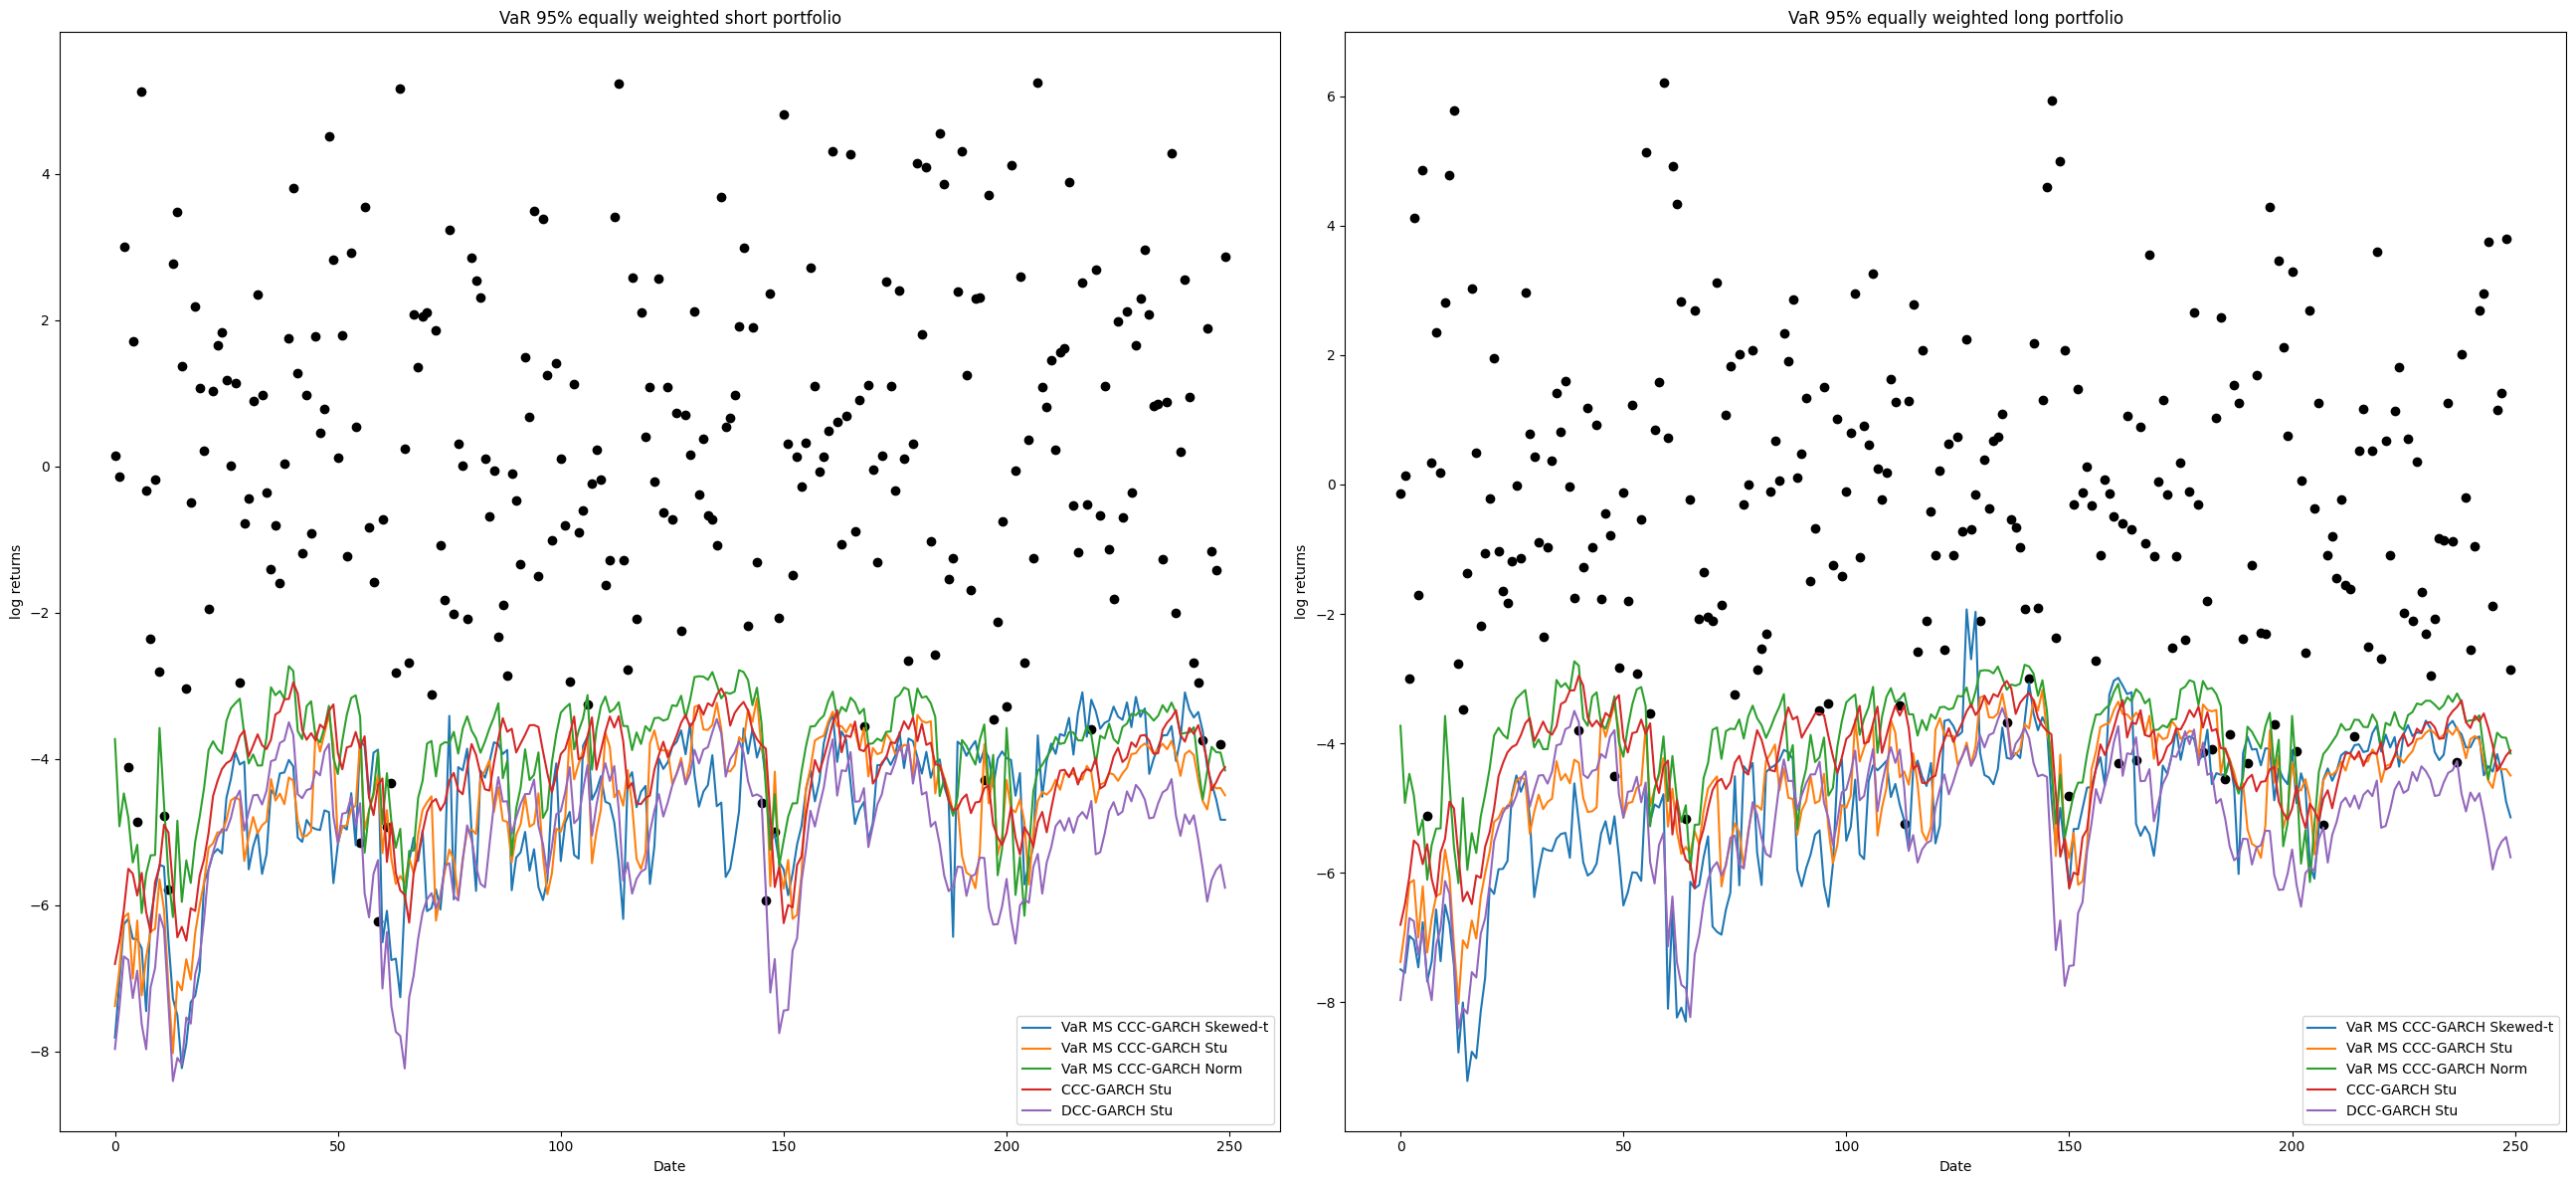

In [95]:
fig_4 = pt.figure_4(var_list_stu_skewed_t_5,var_list_stu_skewed_t_95,var_list_stu,
             var_list_norm,var_list_stu_single,var_list_stu_dcc,rret_short,rret_long)
plt.show(fig_4)

# Table 11 Kupiec and Christoffersen tests

### Short

In [96]:
violations_stu = (np.array([x*-1 for x in var_list_stu]) > rret_short).astype(int)
violations_stu_dcc = (np.array([x*-1 for x in var_list_stu_dcc]) > rret_short).astype(int)
violations_norm = (np.array([x*-1 for x in var_list_norm]) > rret_short).astype(int)
violations_skew = (np.array([x for x in var_list_stu_skewed_t_5]) > rret_short).astype(int)
violations_stu_single = (np.array([x*-1 for x in var_list_stu_single]) > rret_short).astype(int)

In [97]:
ut.var_table([violations_stu_single,violations_norm,violations_stu,violations_skew,violations_stu_dcc])

Failure rate of 2.0%
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
Failure rate of 4.4%
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
Failure rate of 2.8%
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
Failure rate of 2.8%
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
Failure rate of 1.6%
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL


,Violation ratio,Kupiec,Christoffersen
0,0.02,0.01,0.34
0,0.04,0.66,0.36
0,0.03,0.08,0.06
0,0.03,0.08,0.64
0,0.02,0.00,0.13


### long

In [98]:
long_violations_stu = (np.array([x*-1 for x in var_list_stu]) > rret_long).astype(int)
long_violations_stu_dcc = (np.array([x*-1 for x in var_list_stu_dcc]) > rret_long).astype(int)
long_violations_norm = (np.array([x*-1 for x in var_list_norm]) > rret_long).astype(int)
long_violations_skew = (np.array([x*-1 for x in var_list_stu_skewed_t_95]) > rret_long).astype(int)
long_violations_stu_single = (np.array([x*-1 for x in var_list_stu_single]) > rret_long).astype(int)

In [99]:
ut.var_table([long_violations_stu_single,long_violations_norm,long_violations_stu,long_violations_skew,long_violations_stu_dcc])

Failure rate of 4.4%
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
Failure rate of 6.4%
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
Failure rate of 4.0%
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
Failure rate of 2.4%
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
Failure rate of 3.2%
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL


,Violation ratio,Kupiec,Christoffersen
0,0.04,0.66,0.83
0,0.06,0.33,0.87
0,0.04,0.45,0.93
0,0.02,0.04,0.93
0,0.03,0.16,0.45


# Engele-Colacito GMVP test

In [100]:
window_size = 550
n = 3
h = 1
f_end = 300

In [101]:
portfolio_ret_msgarch_norm = []

ones = np.ones(n)
res_fix = res_AR_norm.x
for i in tqdm(range(0,f_end,h)):

    ret_temp = df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].values
    tstamp = str(df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].iloc[-1].name.date()).replace('-','_')

    filename = f'fcst_ar_norm/res_{tstamp}.pkl'
    if os.path.exists(filename):
        res_temp = pd.read_pickle(filename)
        mgarch_gpe_ar = mgarch(dist='t',regime_mean=False,ar = True,regime_ar=False,ret = ret_temp, init_params=res_temp)
    else:
        mgarch_gpe_ar = mgarch(dist='t',regime_mean=False,ar = True,regime_ar=False,ret = ret_temp)

    xsi,chi,condcorr,est,h1,h2,loglik = mgarch_gpe_ar.get_smoothed_prob(res_fix)
    w1,w2,phi1,phi2,A1,A2,B1,B2,G,p,q,nu,P,R1,R2,sigma1init,sigma2init,pinit  = mgarch_gpe_ar.params_for_fcst_ar(res_fix)
    sigmafore, condcov, condcorr  = mgarch_gpe_ar.forecastst(w1, w2, A1, A2, B1, B2, P, R1, R2, G, G, sigma1init, sigma2init, pinit,nu, h)   
    cov_m = condcov[-1]
    
    
    d = i + h

    for d_ar in range(0,h):
        if f_end -i - 1 == 0:
            inv_cov_matrix = np.linalg.inv(cov_m)
            # Ones vector
            ones = np.ones(len(cov_m))
            # Calculate gmvp weights
            w_gmvp = inv_cov_matrix @ ones / (ones.T @ inv_cov_matrix @ ones)

            ret_pnl = df_backtest.iloc[-h:].iloc[d_ar]

            pnl_d = ret_pnl.values @ w_gmvp.T
            portfolio_ret_msgarch_norm.append(pnl_d)

        else:
            inv_cov_matrix = np.linalg.inv(cov_m)
            # Ones vector
            ones = np.ones(len(cov_m))
            # Calculate gmvp weights
            w_gmvp = inv_cov_matrix @ ones / (ones.T @ inv_cov_matrix @ ones)

            ret_pnl = df_backtest.iloc[:-f_end+d].iloc[-h:].iloc[d_ar]
            
            pnl_d = ret_pnl.values @ w_gmvp.T
            portfolio_ret_msgarch_norm.append(pnl_d)

100%|██████████| 300/300 [00:28<00:00, 10.37it/s]


In [102]:
portfolio_ret_dcc = []

res_fix = estdcct.x

for i in tqdm(range(0,f_end,h)):
    ret_temp = df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].values
    tstamp = str(df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].iloc[-1].name.date()).replace('-','_')
    filename = f'fcst_dcc_stu/res_{tstamp}.pkl'
    if os.path.exists(filename):
        res_temp = pd.read_pickle(filename)
        stu_dcc = dcc(ret = ret_temp,dist = 't')
    else:
        stu_dcc = dcc(ret = ret_temp,dist = 't')

    Q, R, h_dcc, S, w, A, B, G, alpha, beta, nu =  stu_dcc.tdccfore(res_fix)
    dcc_fore  =  stu_dcc.dccsim(Q, R, h_dcc, S, w, A, B, G, alpha, beta, nu, 1)
    cov_m = np.reshape(dcc_fore[:,0], (3, 3))
    
    d = i + h

    for d_ar in range(0,h):
        if f_end -i - 1 == 0:
            inv_cov_matrix = np.linalg.inv(cov_m)
            # Ones vector
            ones = np.ones(len(cov_m))
            # Calculate gmvp weights
            w_gmvp = inv_cov_matrix @ ones / (ones.T @ inv_cov_matrix @ ones)

            ret_pnl = df_backtest.iloc[-h:].iloc[d_ar]

            pnl_d = ret_pnl.values @ w_gmvp.T
            portfolio_ret_dcc.append(pnl_d)
        else:
            inv_cov_matrix = np.linalg.inv(cov_m)
            # Ones vector
            ones = np.ones(len(cov_m))
            # Calculate gmvp weights
            w_gmvp = inv_cov_matrix @ ones / (ones.T @ inv_cov_matrix @ ones)


            ret_pnl = df_backtest.iloc[:-f_end+d].iloc[-h:].iloc[d_ar]
            
            pnl_d = ret_pnl.values @ w_gmvp.T
            portfolio_ret_dcc.append(pnl_d)


  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:07<00:00, 42.81it/s]


In [103]:

portfolio_ret_msgarch_stu = []

ones = np.ones(n)

res_fix = res_AR_stu.x
for i in tqdm(range(0,f_end,h)):

    ret_temp = df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].values
    tstamp = str(df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].iloc[-1].name.date()).replace('-','_')

    filename = f'fcst_ar_stu/res_{tstamp}.pkl'
    if os.path.exists(filename):
        res_temp = pd.read_pickle(filename)
        mgarch_gpe_ar = mgarch(dist='t',regime_mean=False,ar = True,regime_ar=False,ret = ret_temp, init_params=res_temp)
    else:
        mgarch_gpe_ar = mgarch(dist='t',regime_mean=False,ar = True,regime_ar=False,ret = ret_temp,)

        
    xsi,chi,condcorr,est,h1,h2,loglik = mgarch_gpe_ar.get_smoothed_prob(res_fix)
    w1,w2,phi1,phi2,A1,A2,B1,B2,G,p,q,nu,P,R1,R2,sigma1init,sigma2init,pinit  = mgarch_gpe_ar.params_for_fcst_ar(res_fix)
    sigmafore, condcov, condcorr  = mgarch_gpe_ar.forecastst(w1, w2, A1, A2, B1, B2, P, R1, R2, G, G, sigma1init, sigma2init, pinit,nu, h)   
    cov_m = condcov[-1]
    
    d = i + h

    for d_ar in range(0,h):
        if f_end -i - 1 == 0:
            inv_cov_matrix = np.linalg.inv(cov_m)
            # Ones vector
            ones = np.ones(len(cov_m))
            # Calculate gmvp weights
            w_gmvp = inv_cov_matrix @ ones / (ones.T @ inv_cov_matrix @ ones)

            ret_pnl = df_backtest.iloc[-h:].iloc[d_ar]

            pnl_d = ret_pnl.values @ w_gmvp.T
            portfolio_ret_msgarch_stu.append(pnl_d)

        else:
            inv_cov_matrix = np.linalg.inv(cov_m)
            # Ones vector
            ones = np.ones(len(cov_m))
            # Calculate gmvp weights
            w_gmvp = inv_cov_matrix @ ones / (ones.T @ inv_cov_matrix @ ones)

            ret_pnl = df_backtest.iloc[:-f_end+d].iloc[-h:].iloc[d_ar]
            
            pnl_d = ret_pnl.values @ w_gmvp.T
            portfolio_ret_msgarch_stu.append(pnl_d)



100%|██████████| 300/300 [00:29<00:00, 10.24it/s]


In [104]:
portfolio_ret_single_stu = []

res_fix = res_single_stu.x
ones = np.ones(n)

for i in tqdm(range(0,f_end,h)):

    ret_temp = df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].values
    tstamp = str(df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].iloc[-1].name.date()).replace('-','_')

    filename = f'fcst_single_stu/res_{tstamp}.pkl'
    if os.path.exists(filename):
        res_temp = pd.read_pickle(filename)
        mgarch_single_stu = mgarch_single(dist='t',ret = ret_temp, init_params=res_temp)
    else:
        mgarch_single_stu = mgarch_single(dist='t',ret = ret_temp)
        '''res_temp = mgarch_single_stu.fit()
        pd.to_pickle(res_temp.x,filename)
        res_temp = res_temp.x'''

    sinit,mu, w, A, B, G, R,nu = mgarch_single_stu.stusinglefore(res_fix)

    cov_m = mgarch_single_stu.forecast_single_stu(w, A, B, G, R, sinit,nu, 1)
    
    
    d = i + h

    for d_ar in range(0,h):
        if f_end -i - 1 == 0:
            inv_cov_matrix = np.linalg.inv(cov_m)  # Inverse of the covariance matrix
            w_gmvp = inv_cov_matrix.dot(ones) / ones.dot(inv_cov_matrix).dot(ones)

            ret_pnl = df_backtest.iloc[-h:].iloc[d_ar]

            pnl_d = ret_pnl.values @ w_gmvp.T
            portfolio_ret_single_stu.append(pnl_d)

        else:
            inv_cov_matrix = np.linalg.inv(cov_m)  # Inverse of the covariance matrix
            w_gmvp = inv_cov_matrix.dot(ones) / ones.dot(inv_cov_matrix).dot(ones)


            ret_pnl = df_backtest.iloc[:-f_end+d].iloc[-h:].iloc[d_ar]
            
            pnl_d = ret_pnl.values @ w_gmvp.T
            portfolio_ret_single_stu.append(pnl_d)

100%|██████████| 300/300 [00:05<00:00, 55.20it/s]


# Table 10 Engle-Colacito test results

In [105]:
list_ret = [
    portfolio_ret_single_stu[:],
    portfolio_ret_msgarch_norm[:],
    portfolio_ret_msgarch_stu[:],
    portfolio_ret_dcc[:]
]

ut.engle_colacito_table(list_ret)


Coefficient Matrix:
[[-0.          0.12896326 -0.2079928   0.0572734 ]
 [-0.12896326 -0.         -0.33695607 -0.07168987]
 [ 0.2079928   0.33695607 -0.          0.2652662 ]
 [-0.0572734   0.07168987 -0.2652662  -0.        ]]

P-Value Matrix:
[[0.         0.35129966 0.06087855 0.55770407]
 [0.35129966 0.         0.02349111 0.69392643]
 [0.06087855 0.02349111 0.         0.03446794]
 [0.55770407 0.69392643 0.03446794 0.        ]]


# Portfolio optimization

## Short only

### GMVP

In [106]:
window_size = 525
n = 3
h = 1

f_end = 250
xsi_list = []
mu_list = []

pnl_gmvp = []

w_list_gmvp = []

date = []

for i in tqdm(range(0,f_end,h)):

    ret_temp = df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].values
    tstamp = str(df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].iloc[-1].name.date()).replace('-','_')
    
    filename = f'fcst_ar_stu/res_{tstamp}.pkl'
    if os.path.exists(filename):
        res_temp = pd.read_pickle(filename)
        mgarch_gpe_ar = mgarch(dist='t',regime_mean=False,ar = True,regime_ar=False,ret = ret_temp, init_params=res_temp)
    else:
        mgarch_gpe_ar = mgarch(dist='t',regime_mean=False,ar = True,regime_ar=False,ret = ret_temp,init_params=res_temp)

    xsi,chi,condcorr,est,h1,h2,loglik = mgarch_gpe_ar.smooth_prob_stu(res_temp)
    w1,w2,phi1,phi2,A1,A2,B1,B2,G,p,q,nu,P,R1,R2,sigma1init,sigma2init,pinit  = mgarch_gpe_ar.params_for_fcst_ar(res_temp)
    sigmafore, condcov, condcorr  = mgarch_gpe_ar.forecastst(w1, w2, A1, A2, B1, B2, P, R1, R2, G, G, sigma1init, sigma2init, pinit,nu, h)   
    cov_m = condcov[-1]
    
    
    d = i + h

    for d_ar in range(0,h):
        if f_end -i - 1 ==0:
            mu = res_temp[:n]+ (df_backtest.iloc[-(f_end -i):].iloc[d_ar].values-res_temp[:n]) * phi1
            def get_ret_vol_sr(weights): 
                weights = np.array(weights)
                ret = np.dot(mu, weights)
                vol = np.sqrt(np.dot(weights.T, np.dot(cov_m, weights)))
                return vol

            def check_sum(weights): 
                return np.sum(np.abs(weights)) - 1


            cons = ({'type':'eq','fun':check_sum})

            bounds = ((-1,0),(-1,0),(-1,0))
            init_guess = [-0.33, -0.33, -0.33]

            weights = minimize(get_ret_vol_sr, init_guess, method='SLSQP', bounds=bounds, constraints=cons).x
            
            w_list_gmvp.append(weights)

            ret_pnl_gmvp = df_backtest.iloc[-h:].iloc[d_ar]
            date.append(df_backtest.iloc[-h:].iloc[d_ar].name)

            pnl_gmvp_d = ret_pnl_gmvp.values @ weights.T
            pnl_gmvp.append(pnl_gmvp_d)

        else:
            mu = res_temp[:n]+ (df_backtest.iloc[:-f_end+d].iloc[-h-1:].iloc[d_ar].values-res_temp[:n]) * phi1

            def get_ret_vol_sr(weights): 
                weights = np.array(weights)
                ret = np.dot(mu, weights)
                vol = np.sqrt(np.dot(weights.T, np.dot(cov_m, weights)))

                return vol

            def check_sum(weights): 
                return np.sum(np.abs(weights)) - 1


            cons = ({'type':'eq','fun':check_sum})

            bounds = ((-1,0),(-1,0),(-1,0))
            init_guess = [-0.33, -0.33, -0.33]

            weights = minimize(get_ret_vol_sr, init_guess, method='SLSQP', bounds=bounds, constraints=cons).x
            
            w_list_gmvp.append(weights)

            ret_pnl_gmvp = df_backtest.iloc[:-f_end+d].iloc[-h:].iloc[d_ar]
            date.append(df_backtest.iloc[:-f_end+d].iloc[-h:].iloc[d_ar].name)

            pnl_gmvp_d = ret_pnl_gmvp.values @ weights.T
            pnl_gmvp.append(pnl_gmvp_d)



100%|██████████| 250/250 [00:23<00:00, 10.72it/s]


### Max Sharpe

In [107]:
window_size = 525
n = 3
h = 1

f_end = 250
xsi_list = []

pnl_sharpe_short = []

w_list_sharpe_short = []

date = []

for i in tqdm(range(0,f_end,h)):

    ret_temp = df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].values
    tstamp = str(df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].iloc[-1].name.date()).replace('-','_')
    
    filename = f'fcst_ar_stu/res_{tstamp}.pkl'
    if os.path.exists(filename):
        res_temp = pd.read_pickle(filename)
        mgarch_gpe_ar = mgarch(dist='t',regime_mean=False,ar = True,regime_ar=False,ret = ret_temp, init_params=res_temp)
    else:
        mgarch_gpe_ar = mgarch(dist='t',regime_mean=False,ar = True,regime_ar=False,ret = ret_temp,init_params=res_temp)

    xsi,chi,condcorr,est,h1,h2,loglik = mgarch_gpe_ar.smooth_prob_stu(res_temp)
    w1,w2,phi1,phi2,A1,A2,B1,B2,G,p,q,nu,P,R1,R2,sigma1init,sigma2init,pinit  = mgarch_gpe_ar.params_for_fcst_ar(res_temp)
    sigmafore, condcov, condcorr  = mgarch_gpe_ar.forecastst(w1, w2, A1, A2, B1, B2, P, R1, R2, G, G, sigma1init, sigma2init, pinit,nu, h)   
    cov_m = condcov[-1]
    
    
    d = i + h

    for d_ar in range(0,h):
        if f_end -i - 1 ==0:
            mu = res_temp[:n]+ (df_backtest.iloc[-(f_end -i):].iloc[d_ar].values-res_temp[:n]) * phi1
            def get_ret_vol_sr(weights): 
                weights = np.array(weights)
                ret = np.dot(mu, weights)
                vol = np.sqrt(np.dot(weights.T, np.dot(cov_m, weights)))
                return -ret/vol

            def check_sum(weights): 
                return np.sum(np.abs(weights)) - 1


            cons = ({'type':'eq','fun':check_sum})

            bounds = ((-1,0),(-1,0),(-1,0))
            init_guess = [-0.33, -0.33, -0.33]

            weights = minimize(get_ret_vol_sr, init_guess, method='SLSQP', bounds=bounds, constraints=cons).x
            
            w_list_sharpe_short.append(weights)

            ret_pnl_sharpe_short = df_backtest.iloc[-h:].iloc[d_ar]
            date.append(df_backtest.iloc[-h:].iloc[d_ar].name)

            pnl_sharpe_short_d = ret_pnl_sharpe_short.values @ weights.T
            pnl_sharpe_short.append(pnl_sharpe_short_d)

        else:
            mu = res_temp[:n]+ (df_backtest.iloc[:-f_end+d].iloc[-h-1:].iloc[d_ar].values-res_temp[:n]) * phi1

            def get_ret_vol_sr(weights): 
                weights = np.array(weights)
                ret = np.dot(mu, weights)
                vol = np.sqrt(np.dot(weights.T, np.dot(cov_m, weights)))

                return -ret/vol

            def check_sum(weights): 
                return np.sum(np.abs(weights)) - 1


            cons = ({'type':'eq','fun':check_sum})

            bounds = ((-1,0),(-1,0),(-1,0))
            init_guess = [-0.33, -0.33, -0.33]

            weights = minimize(get_ret_vol_sr, init_guess, method='SLSQP', bounds=bounds, constraints=cons).x
            
            w_list_sharpe_short.append(weights)

            ret_pnl_sharpe_short = df_backtest.iloc[:-f_end+d].iloc[-h:].iloc[d_ar]
            date.append(df_backtest.iloc[:-f_end+d].iloc[-h:].iloc[d_ar].name)

            pnl_sharpe_short_d = ret_pnl_sharpe_short.values @ weights.T
            pnl_sharpe_short.append(pnl_sharpe_short_d)

  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 250/250 [00:28<00:00,  8.89it/s]


### Equally weighted

In [108]:
condcov_l, condcorr_l  = [],[]
window_size = 525
n = 3
h = 1

f_end = 250
xsi_list = []
mu_list = []

pnl_equal = []

w_list = []

date = []

for i in tqdm(range(0,f_end,h)):

    ret_temp = df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].values
    tstamp = str(df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].iloc[-1].name.date()).replace('-','_')
    

    d = i + h

    for d_ar in range(0,h):
        if f_end -i - 1 ==0:
            weights = np.array([-0.33, -0.33, -0.33])
            
            w_list.append(weights)

            ret_pnl_equal = df_backtest.iloc[-h:].iloc[d_ar]
            date.append(df_backtest.iloc[-h:].iloc[d_ar].name)

            pnl_equal_d = ret_pnl_equal.values @ weights.T
            pnl_equal.append(pnl_equal_d)
            mu_list.append(mu)

        else:
            
            init_guess = [-0.33, -0.33, -0.33]

            weights = np.array([-0.33, -0.33, -0.33])
            
            w_list.append(weights)

            ret_pnl_equal = df_backtest.iloc[:-f_end+d].iloc[-h:].iloc[d_ar]
            date.append(df_backtest.iloc[:-f_end+d].iloc[-h:].iloc[d_ar].name)

            pnl_equal_d = ret_pnl_equal.values @ weights.T
            pnl_equal.append(pnl_equal_d)
            mu_list.append(mu)



100%|██████████| 250/250 [00:00<00:00, 3485.84it/s]


### Min CVaR

In [109]:
window_size = 525
# seed is fixed for CVaR optimization as monte carlo simulation can lead to difference in final portfolio result
np.random.seed(777)
n = 3
h = 1

f_end = 250
xsi_list = []
mu_list = []

pnl_model_skew_short = []

w_list_cvar_short = []

for i in tqdm(range(0,f_end,h)):

    ret_temp = df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].values
    tstamp = str(df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].iloc[-1].name.date()).replace('-','_')

    filename = f'fcst_ar_skew/res_{tstamp}.pkl'

    if os.path.exists(filename):
        res_temp = pd.read_pickle(filename)
        mgarch_gpe_ar_skewed_t = mgarch(dist='skewed_t',regime_mean=False,ar = True,regime_ar=False,ret = ret_temp)
    else:
        mgarch_gpe_ar_skewed_t = mgarch(dist='skewed_t',regime_mean=False,ar = True,regime_ar=False,ret = ret_temp)


    w1,w2,phi1,phi2,A1,A2,B1,B2,G,p,q,nu,P,R1,R2,sigma1init,sigma2init,pinit,gam = mgarch_gpe_ar_skewed_t.params_for_fcst_ar_skewed_t(res_temp)
    mu = res_temp[:n]
    Rt = ut.skew_t_MCMC(mu,w1,w2,phi1,phi2,A1,A2,B1,B2,G,p,q,nu,P,R1,R2,sigma1init,sigma2init,pinit,gam,ret_temp,d = 3,N = 2000,T=1)
    d = i + h

    for d_ar in range(0,h):
        if f_end -i - 1 == 0:
            
            cons = (

            # Sum of weights must equate to 1
            {'type': 'eq', 'fun': lambda weights: np.sum(np.abs(weights)) - 1})
            bounds = ((-1,0),(-1,0),(-1,0))
            init_guess = [-0.33, -0.33, -0.33]


            def objective(weights):
                weights_m = weights[:, np.newaxis, np.newaxis]
                # Calculate weighted returns and sum across the assets dimension
                portfolio_returns = np.sum(Rt * weights_m, axis=0)

                # Assuming portfolio_returns is the array of shape (1, 1000) with portfolio returns for each simulation
                portfolio_returns = np.sort(portfolio_returns.flatten())  #
                # Calculate the threshold index for the given confidence level
                index = int(np.floor(0.05 * len(portfolio_returns)))
                # Calculate the ES as the average of the worst outcomes
                es = np.mean(portfolio_returns[:index])
                return -(es)

            weights = minimize(objective, init_guess, method='SLSQP', bounds=bounds, constraints=cons).x

            ret_pnl = df_backtest.iloc[-h:].iloc[d_ar]
            pnl_d = ret_pnl.values @ weights.T
            pnl_model_skew_short.append(pnl_d)
            w_list_cvar_short.append(weights)
            
        else:
            cons = (
            # Sum of weights must equate to 1
            {'type': 'eq', 'fun': lambda weights: np.sum(np.abs(weights)) - 1}
            )
            bounds = ((-1,0),(-1,0),(-1,0))
            init_guess = [-0.33, -0.33, -0.33]


            def objective(weights):
                weights_m = weights[:, np.newaxis, np.newaxis]
                # Calculate weighted returns and sum across the assets dimension
                portfolio_returns = np.sum(Rt * weights_m, axis=0)

                # Assuming portfolio_returns is the array of shape (1, 1000) with portfolio returns for each simulation
                portfolio_returns = np.sort(portfolio_returns.flatten())  #
                # Calculate the threshold index for the given confidence level
                index = int(np.floor(0.05 * len(portfolio_returns)))
                # Calculate the ES as the average of the worst outcomes
                es = np.mean(portfolio_returns[:index])
                return -(es)

            weights = minimize(objective, init_guess, method='SLSQP', bounds=bounds, constraints=cons).x

            ret_pnl = df_backtest.iloc[:-f_end+d].iloc[-h:].iloc[d_ar]

            pnl_d = ret_pnl.values @ weights.T
            pnl_model_skew_short.append(pnl_d)
            w_list_cvar_short.append(weights)

100%|██████████| 250/250 [04:40<00:00,  1.12s/it]


# Table 12

In [110]:
ut.return_portfolio_stats(pnl_equal)

,TR,MR,Risk,SR,MDD
0,48.98,0.2,2.32,1.34,11.34


In [111]:
ut.return_portfolio_stats(pnl_gmvp)

,TR,MR,Risk,SR,MDD
0,45.46,0.18,1.94,1.49,10.51


In [112]:
ut.return_portfolio_stats(pnl_sharpe_short)

,TR,MR,Risk,SR,MDD
0,74.17,0.3,2.72,1.73,15.6


In [113]:
ut.return_portfolio_stats(pnl_model_skew_short)

,TR,MR,Risk,SR,MDD
0,43.35,0.17,1.95,1.41,10.42


## long short

### Max Sharpe Long-Short

In [114]:
condcov_l, condcorr_l  = [],[]
window_size = 550
n = 3
h = 1

f_end = 250


pnl_sharpe_long = []
w_list_sharpe_long = []

date = []

for i in tqdm(range(0,f_end,h)):

    ret_temp = df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].values
    tstamp = str(df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].iloc[-1].name.date()).replace('-','_')
    
    filename = f'fcst_ar_stu/res_{tstamp}.pkl'
    if os.path.exists(filename):
        res_temp = pd.read_pickle(filename)
        mgarch_gpe_ar = mgarch(dist='t',regime_mean=False,ar = True,regime_ar=False,ret = ret_temp, init_params=res_temp)
    else:
        mgarch_gpe_ar = mgarch(dist='t',regime_mean=False,ar = True,regime_ar=False,ret = ret_temp)
        '''res_temp = mgarch_gpe_ar.fit()
        pd.to_pickle(res_temp.x,filename)  
        res_temp = res_temp.x'''

    xsi,chi,condcorr,est,h1,h2,loglik = mgarch_gpe_ar.smooth_prob_stu(res_temp)
    w1,w2,phi1,phi2,A1,A2,B1,B2,G,p,q,nu,P,R1,R2,sigma1init,sigma2init,pinit  = mgarch_gpe_ar.params_for_fcst_ar(res_temp)

    sigmafore, condcov, condcorr  = mgarch_gpe_ar.forecastst(w1, w2, A1, A2, B1, B2, P, R1, R2, G, G, sigma1init, sigma2init, pinit,nu, h)   
    A  = np.diag(phi1)
    E = np.eye(n)

    cov_m  = ut.calculate_variance(condcov,A,E,h)    
    
    d = i + h

    for d_ar in range(0,h):
        if f_end -i - h ==0:
            mu = res_temp[:n] + (df_backtest.iloc[-(f_end -i):].iloc[d_ar].values-res_temp[:n]) * phi1
            def get_ret_vol_sr(weights): 
                weights = np.array(weights)
                ret = np.dot(mu, weights)
                vol = np.sqrt(np.dot(weights.T, np.dot(cov_m, weights)))
                sr = ret/vol 
                return sr

            def neg_sharpe(weights): 
                return get_ret_vol_sr(weights) * -1

            def check_sum(weights): 
                return np.sum(np.abs(weights)) - 1


            cons = ({'type':'eq','fun':check_sum})

            bounds = ((-1,1),(-1,1),(-1,1))
            init_guess = [-0.33, -0.33, -0.33]

            weights = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons).x
            
            w_list_sharpe_long.append(weights)

            ret_pnl_sharpe_long = df_backtest.iloc[-h:].iloc[d_ar]
            date.append(df_backtest.iloc[-h:].iloc[d_ar].name)

            pnl_sharpe_long_d = ret_pnl_sharpe_long.values @ weights.T
            pnl_sharpe_long.append(pnl_sharpe_long_d)

        else:
            mu = res_temp[:n] + (df_backtest.iloc[:-f_end+d].iloc[-h-1:].iloc[d_ar].values-res_temp[:n]) * phi1

            def get_ret_vol_sr(weights): 
                weights = np.array(weights)
                ret = np.dot(mu, weights)
                vol = np.sqrt(np.dot(weights.T, np.dot(cov_m, weights)))
                sr = ret/vol 
                return sr

            def neg_sharpe(weights): 
                return get_ret_vol_sr(weights) * -1

            def check_sum(weights): 
                return np.sum(np.abs(weights)) - 1


            cons = ({'type':'eq','fun':check_sum})

            bounds = ((-1,1),(-1,1),(-1,1))
            init_guess = [-0.33, -0.33, -0.33]

            weights = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons).x
            
            w_list_sharpe_long.append(weights)

            ret_pnl_sharpe_long = df_backtest.iloc[:-f_end+d].iloc[-h:].iloc[d_ar]
            date.append(df_backtest.iloc[:-f_end+d].iloc[-h:].iloc[d_ar].name)

            pnl_sharpe_long_d = ret_pnl_sharpe_long.values @ weights.T
            pnl_sharpe_long.append(pnl_sharpe_long_d)


  1%|          | 3/250 [00:00<00:33,  7.29it/s]

100%|██████████| 250/250 [00:29<00:00,  8.45it/s]


### Min CVaR Long-Short

In [115]:
# Portfolio Min CVaR Long-Short
window_size = 525
n = 3
h = 1

f_end = 250
xsi_list = []
mu_list = []

pnl_model_skew_long_short = []

w_list_cvar_long_short = []
np.random.seed(777)

for i in tqdm(range(0,f_end,h)):

    ret_temp = df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].values
    tstamp = str(df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].iloc[-1].name.date()).replace('-','_')

    filename = f'fcst_ar_skew/res_{tstamp}.pkl'

    if os.path.exists(filename):
        res_temp = pd.read_pickle(filename)
        mgarch_gpe_ar_skewed_t = mgarch(dist='skewed_t',regime_mean=False,ar = True,regime_ar=False,ret = ret_temp)
    else:
        mgarch_gpe_ar_skewed_t = mgarch(dist='skewed_t',regime_mean=False,ar = True,regime_ar=False,ret = ret_temp)

    w1,w2,phi1,phi2,A1,A2,B1,B2,G,p,q,nu,P,R1,R2,sigma1init,sigma2init,pinit,gam = mgarch_gpe_ar_skewed_t.params_for_fcst_ar_skewed_t(res_temp)
    mu = res_temp[:n]
    Rt = ut.skew_t_MCMC(mu,w1,w2,phi1,phi2,A1,A2,B1,B2,G,p,q,nu,P,R1,R2,sigma1init,sigma2init,pinit,gam,ret_temp,d = 3,N = 5000,T=1)
    d = i + h

    for d_ar in range(0,h):
        if f_end -i - 1 == 0:
            
            cons = (
            # Sum of weights must equate to 1
            {'type': 'eq', 'fun': lambda weights: np.sum(np.abs(weights)) - 1},
            )
            bounds = ((-1,1),(-1,1),(-1,1))
            init_guess = [-0.33, -0.33, -0.33]


            def objective(weights):
                weights_m = weights[:, np.newaxis, np.newaxis]
                # Calculate weighted returns and sum across the assets dimension
                portfolio_returns = np.sum(Rt * weights_m, axis=0)
                portfolio_returns = np.sort(portfolio_returns.flatten())  #
                # Calculate the threshold index for the given confidence level
                index = int(np.floor(0.05 * len(portfolio_returns)))
                # Calculate the ES as the average of the worst outcomes
                es = np.mean(portfolio_returns[:index])
                return -(es)

            weights = minimize(objective, init_guess, method='SLSQP', bounds=bounds, constraints=cons).x

            ret_pnl = df_backtest.iloc[-h:].iloc[d_ar]
            pnl_d = ret_pnl.values @ weights.T
            pnl_model_skew_long_short.append(pnl_d)
            w_list_cvar_long_short.append(weights)
            
        else:
            cons = (
            # Sum of weights must equate to 1
            {'type': 'eq', 'fun': lambda weights: np.sum(np.abs(weights)) - 1},
            )
            bounds = ((-1,1),(-1,1),(-1,1))
            init_guess = [-0.33, -0.33, -0.33]


            def objective(weights):
                weights_m = weights[:, np.newaxis, np.newaxis]
                # Calculate weighted returns and sum across the assets dimension
                portfolio_returns = np.sum(Rt * weights_m, axis=0)
                portfolio_returns = np.sort(portfolio_returns.flatten())  #
                # Calculate the threshold index for the given confidence level
                index = int(np.floor(0.05 * len(portfolio_returns)))
                # Calculate the ES as the average of the worst outcomes
                es = np.mean(portfolio_returns[:index])
                return -(es)

            weights = minimize(objective, init_guess, method='SLSQP', bounds=bounds, constraints=cons).x

            ret_pnl = df_backtest.iloc[:-f_end+d].iloc[-h:].iloc[d_ar]

            pnl_d = ret_pnl.values @ weights.T
            pnl_model_skew_long_short.append(pnl_d)
            w_list_cvar_long_short.append(weights)

  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 250/250 [11:19<00:00,  2.72s/it]


# Table 13

In [116]:
ut.return_portfolio_stats(pnl_sharpe_long)

,TR,MR,Risk,SR,MDD
0,34.94,0.14,1.4,1.59,9.16


In [117]:
ut.return_portfolio_stats(pnl_model_skew_long_short)

,TR,MR,Risk,SR,MDD
0,25.22,0.1,1.39,1.16,9.86


# Figure 5 Out of sample portfolio returns

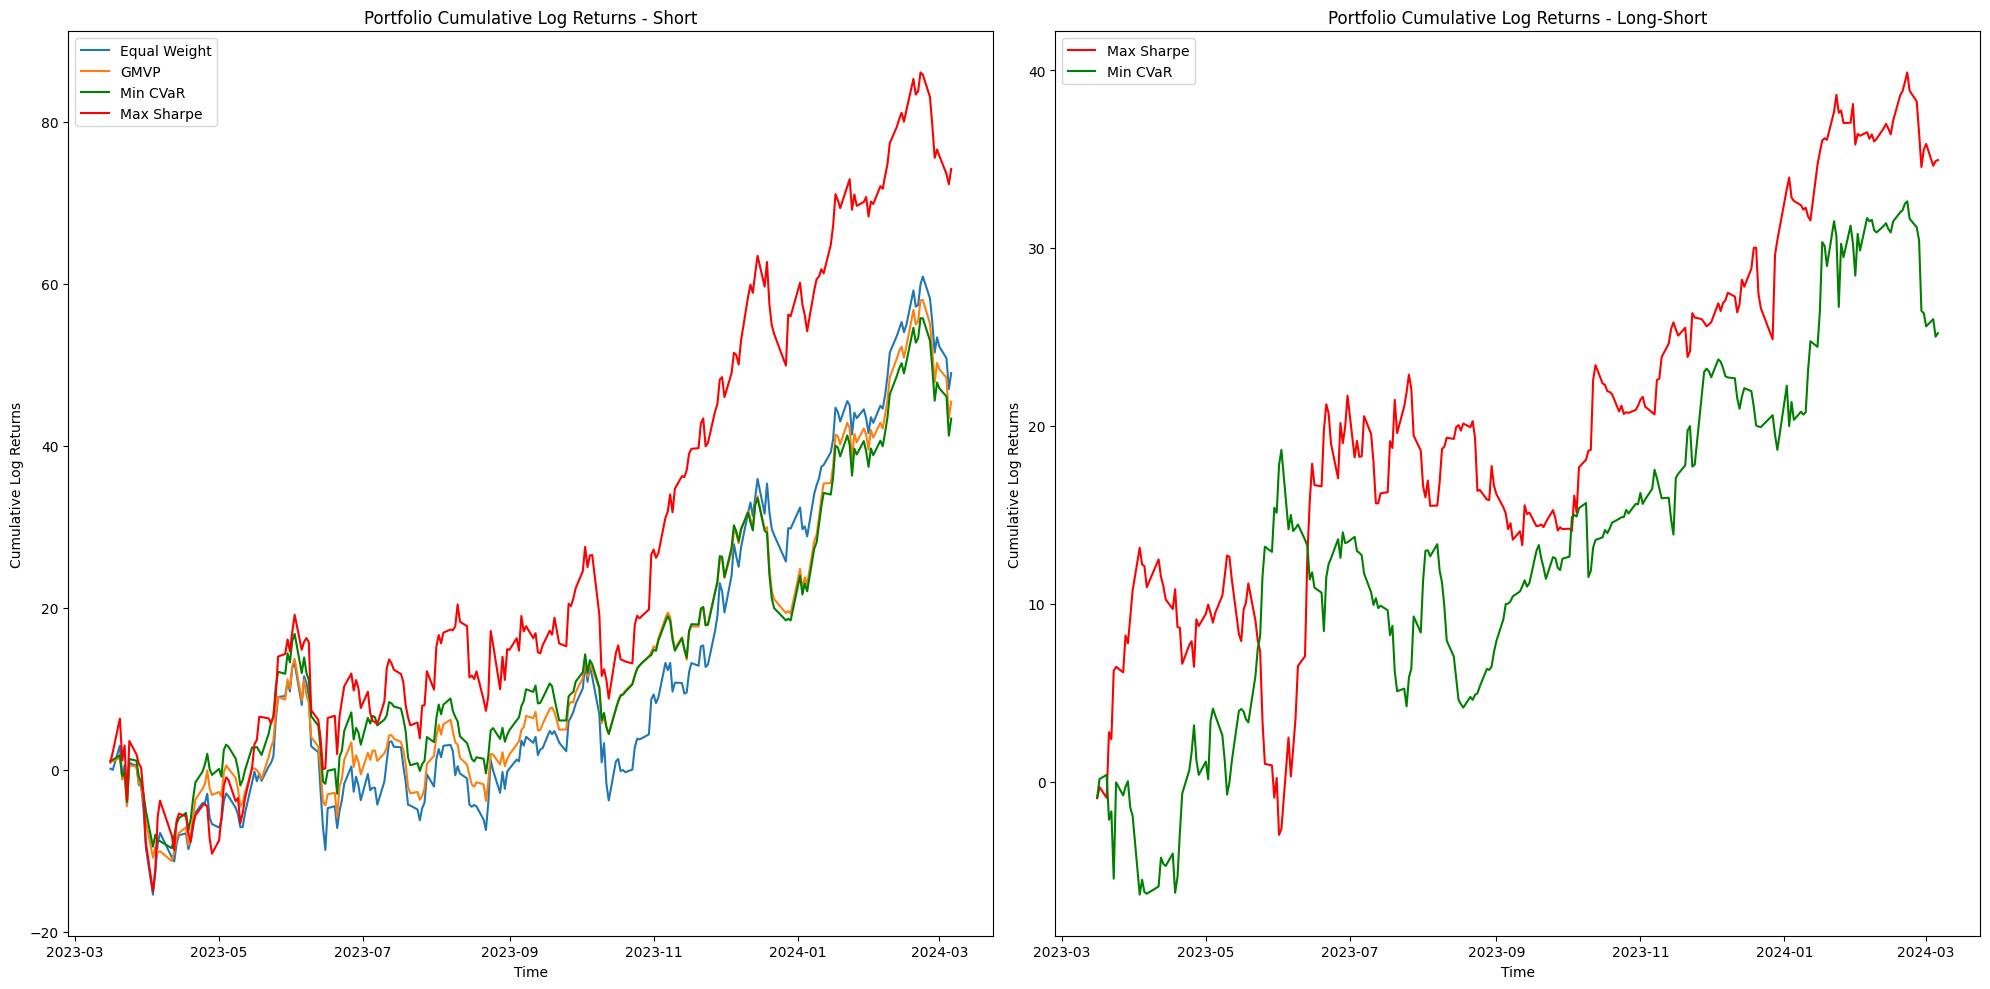

In [118]:
fig = pt.figure_5(df_backtest,pnl_equal,pnl_gmvp,pnl_model_skew_short,pnl_sharpe_short,
             pnl_sharpe_long,pnl_model_skew_long_short,f_end)
plt.show(fig)

# Appendix A.3-A.4 Optimal weights

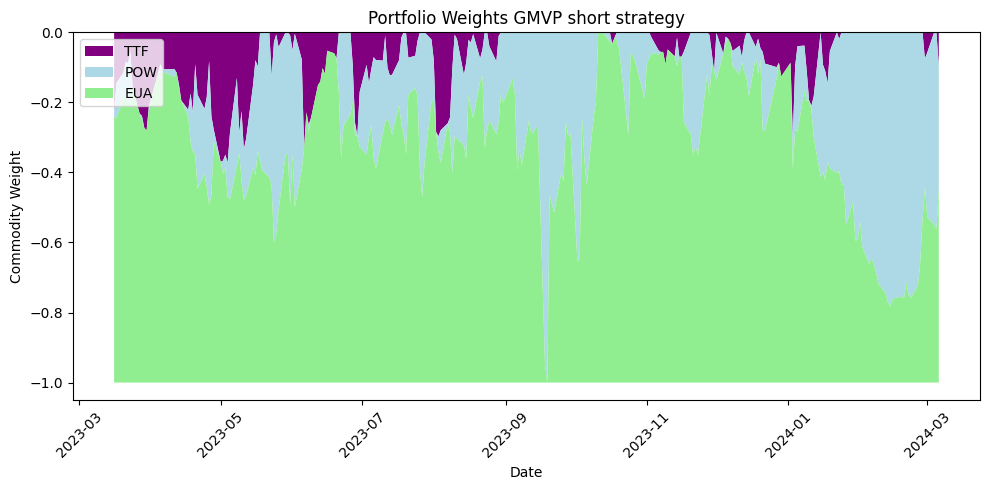

In [119]:
pt.plot_long_short_allocation(ut.create_weights_df(w_list_gmvp,date),'Portfolio Weights GMVP short strategy')

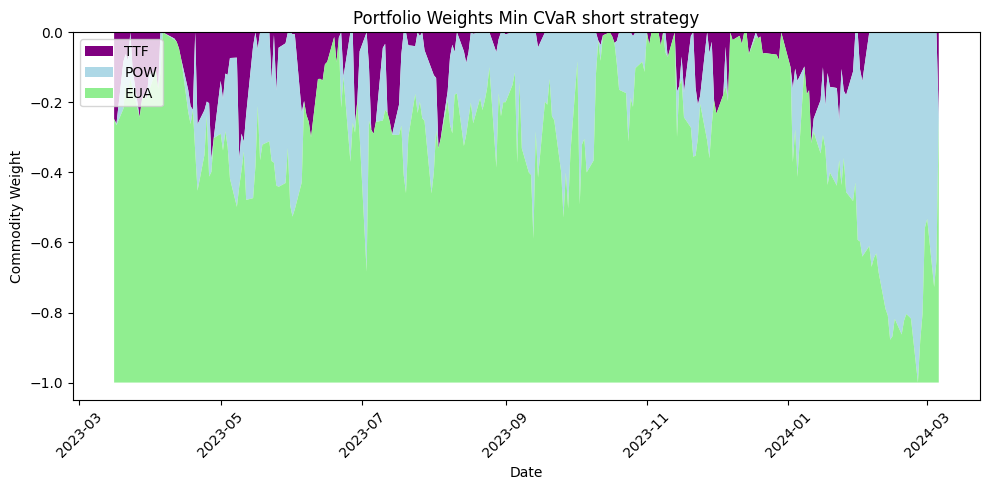

In [120]:
pt.plot_long_short_allocation(ut.create_weights_df(w_list_cvar_short,date),'Portfolio Weights Min CVaR short strategy')

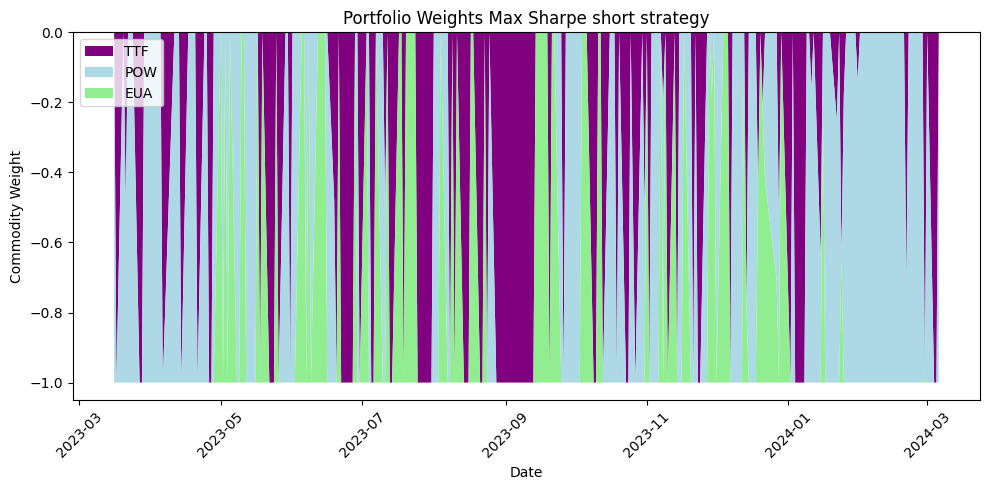

In [121]:
pt.plot_long_short_allocation(ut.create_weights_df(w_list_sharpe_short,date),'Portfolio Weights Max Sharpe short strategy')

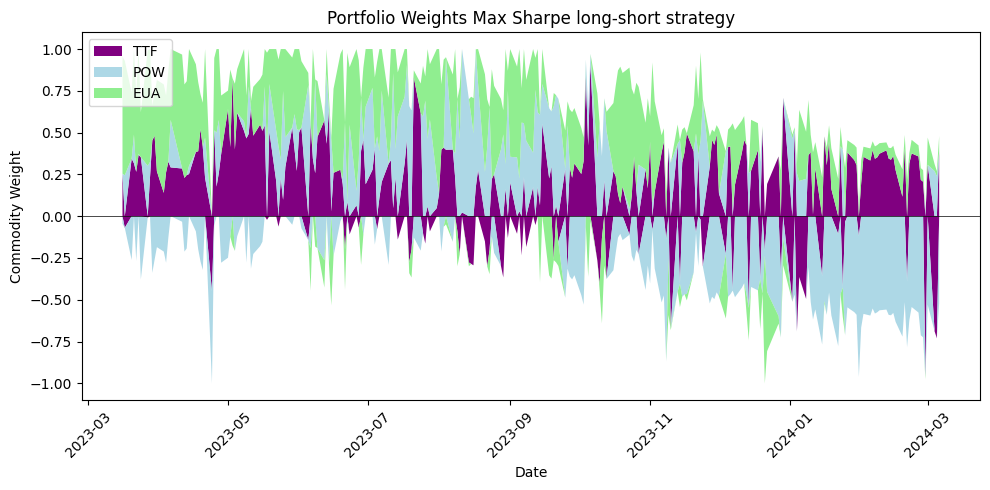

In [122]:
pt.plot_long_short_allocation(ut.create_weights_df(w_list_sharpe_long,date),'Portfolio Weights Max Sharpe long-short strategy')

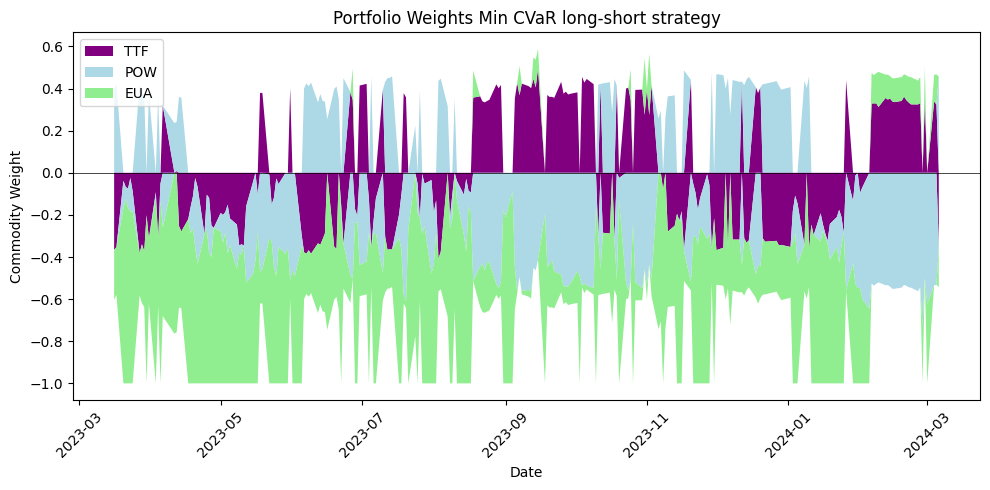

In [123]:
pt.plot_long_short_allocation(ut.create_weights_df(w_list_cvar_long_short,date),'Portfolio Weights Min CVaR long-short strategy')

# Bonus

## Replication of estimation results Haas and Liu 2018 Stu t 

In [124]:
import scipy.io
mat = scipy.io.loadmat('data/indices.mat')
r = mat['Sweek'] 
r_log = 100*np.diff(np.log(r),axis = 0)

In [125]:
mgarch_haas = mgarch(dist='t',regime_mean=False,ar = False,regime_ar=False,ret = r_log)
res_haas = mgarch_haas.fit()
xsi_haas,chi_haas,condcorr,est_haas,h1_haas,h2_haas,loglik_haas = mgarch_haas.get_smoothed_prob(res_haas.x)

In [126]:
est_haas

[array([0.18831216, 0.21667573]),
 array([0.1287805 , 0.10128901]),
 array([0.03859806, 0.16339921]),
 array([0.0733802, 0.0884939]),
 array([0.061665  , 0.05716355]),
 array([0.8899435 , 0.89549321]),
 array([0.92911504, 0.86513309]),
 array([0.62684114, 0.47201788]),
 array([[1.        , 0.92130885],
        [0.92130885, 1.        ]]),
 array([[1.        , 0.65533088],
        [0.65533088, 1.        ]]),
 0.9944988460008635,
 0.9957227126118017,
 8.584520321946018]

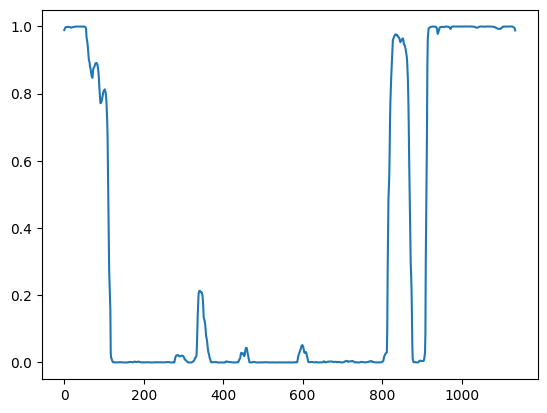

In [127]:
plt.plot(chi_haas[0][1:])
plt.show()

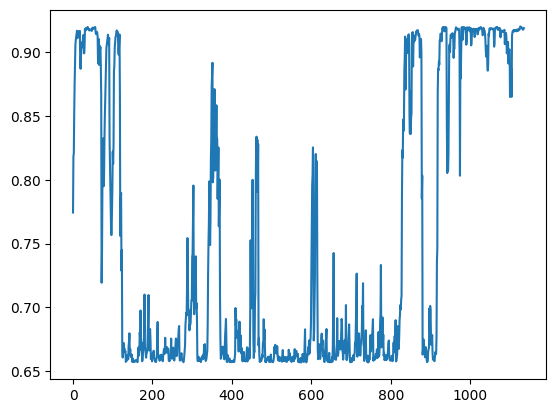

In [128]:
plt.plot(condcorr[:,0,1][1:-1])
plt.show()

## Model estimation for a porfolio of 4 assets (+Brent)

In [129]:
df_comms_ret = pd.read_pickle('data/df_comms_ret_brent')

st_date = '2021-01-01'

# GPE - Gas Power EUA
ret_arr_gpeb = df_comms_ret[st_date:].values
ret_arr_gpeb.shape

(816, 4)

In [130]:
res_AR_stu_brent_init = pd.read_pickle('qmle_fit_res/res_AR_stu_brent').x

In [131]:
mgarch_AR_stu_brent = mgarch(dist='t',regime_mean=False,ar = True,regime_ar=False,ret = ret_arr_gpeb,init_params = res_AR_stu_brent_init)
res_AR_stu_brent = mgarch_AR_stu_brent.fit()

In [132]:
xsi_AR_stu_brent,chi_AR_stu_brent,condcorr_stu_ar,est_AR_stu_brent,h1_AR_stu_brent,h2_AR_stu_brent,loglik_AR_stu_brent = mgarch_AR_stu_brent.get_smoothed_prob(res_AR_stu_brent.x)

In [133]:
est_AR_stu_brent

[array([0.22198797, 0.1477951 , 0.12501304, 0.17572068]),
 array([-0.04661071, -0.04936657, -0.05758447,  0.02046842]),
 array([0.14130813, 0.06476409, 0.02989056, 0.19594059]),
 array([0.80413538, 0.63946141, 0.26070432, 0.19536792]),
 array([0.07438648, 0.09001528, 0.04643168, 0.09931067]),
 array([1.45285080e-01, 1.99877089e-01, 1.30683691e-01, 2.18876798e-08]),
 array([0.89344372, 0.90144841, 0.95052273, 0.81902462]),
 array([0.76544103, 0.72979503, 0.83181206, 0.9284146 ]),
 array([-0.24900036, -0.16174123, -0.06789942,  1.        ]),
 array([[1.        , 0.89388281, 0.54710633, 0.13610057],
        [0.89388281, 1.        , 0.68964435, 0.12754194],
        [0.54710633, 0.68964435, 1.        , 0.1208592 ],
        [0.13610057, 0.12754194, 0.1208592 , 1.        ]]),
 array([[1.        , 0.77011555, 0.09555244, 0.08765392],
        [0.77011555, 1.        , 0.16648403, 0.12056861],
        [0.09555244, 0.16648403, 1.        , 0.07881524],
        [0.08765392, 0.12056861, 0.07881524, 1

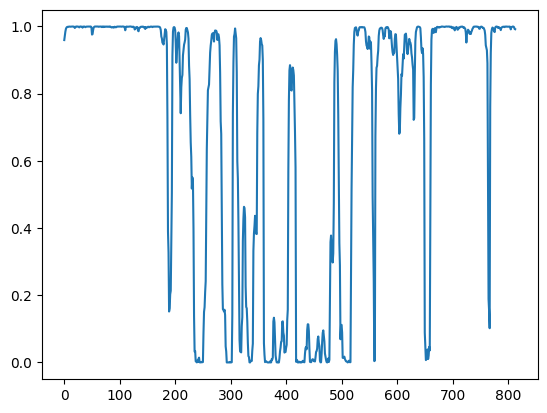

In [134]:
plt.plot(chi_AR_stu_brent[0][1:])
plt.show()